In [1]:
# Import external toolboxes, functions
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap

from scipy.stats import pearsonr, sem, wilcoxon, mode, mannwhitneyu, chi2_contingency, friedmanchisquare
from pycircstat import vtest

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Import custom functions
from parameters import *  # all-caps variables come from here
from util import *
from hht import HHT

### Define some plotting functions

### Figure S1A1
Pupil size distributions for all experiments.

In [3]:
# Load pupil size data for all experimental conditions
conditions = ['spontaneous', 'sparsenoise', 'natmov', 'natmov_opto', 'dark']
labels = ['Gray screen', 'Sparse noise', 'Nat. movie', 'Nat. movie', 'Dark']
df_pupil = load_data('pupil', conditions)

# Print out some metadata
for label, condition in zip(labels, conditions):
    df = df_pupil.query('condition == @condition')
    print(f"{label}: {len(df)} sessions {len(df.groupby('m'))}")

Loading:  pupil_spontaneous.pkl
Loading:  pupil_sparsenoise.pkl
Loading:  pupil_natmov.pkl
Loading:  pupil_natmov_opto.pkl
Loading:  pupil_dark.pkl
Gray screen: 5 sessions 3
Sparse noise: 10 sessions 8
Nat. movie: 2 sessions 2
Nat. movie: 7 sessions 6
Dark: 5 sessions 2


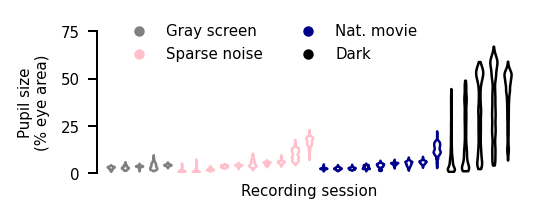

In [4]:
fig, ax = plt.subplots()

# Combine movie experiments with and without optogenetic stimulation 
df_pupil.loc[df_pupil['condition'] == 'natmov_opto', 'condition'] = 'natmov'

# Get mean pupil area to sort distributions within each condition
df_pupil['pupil_area_mean'] = df_pupil['pupil_area'].apply(lambda x: np.nanmean(x))

# Set a starting x-porunion
p0 = 1

# Loop over experimental condition
conditions = ['spontaneous', 'sparsenoise', 'natmov', 'dark']
labels = ['Gray screen', 'Sparse noise', 'Nat. movie', 'Dark']
for condition, label in zip(conditions, labels):
    df_condition = df_pupil.query('condition == @condition')
    
    # Sort experiments by mean area
    df_condition = df_condition.sort_values('pupil_area_mean')
    
    # Plot distributions
    porunions = np.arange(p0, p0 + len(df_condition))
    distributions = [row['pupil_area'] for idx, row in df_condition.iterrows()]
    violins = ax.violinplot(distributions, porunions, showextrema=False)
    
    # Change color of violins
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(COLORS[condition])
        violin.set_linewidth(1)
        violin.set_alpha(1)
        
    # Increment porunion counter
    p0 += len(df_condition)
    
    # Plot a dummy data point for legend
    ax.scatter(-1, -1, c=COLORS[condition], s=10, label=label)
    
# Format x-axis
ax.set_xticks([])
ax.set_xlim(left=0, right=len(df_pupil) + 1)
ax.set_xlabel('Recording session')

# Format y-axis
ax.set_yticks([0, .25, .5, .75])
ax.set_yticklabels(["0", "25", "50", "75"])
ax.set_ylim(bottom=0, top=0.75)
ax.set_ylabel('Pupil size\n(% eye area)')

ax.legend(frameon=False, ncol=2, loc=(0.05, 0.75))
clip_axes_to_ticks(spines=['left'])
set_plotsize(w=6, h=2)
fig.savefig(FIGUREPATH + 'pupil_area_distribution' + FIGSAVEFORMAT)

### Figure S1A2
Power spectral density (PSD) across gray screen and dark conditions.

In [5]:
# Load data from gray screen and dark experiments
conditions = ['spontaneous', 'dark']
labels = ['Gray screen', 'Dark']
df_hht = load_data('hht', ['spontaneous', 'dark'])

# Interpolate and normalize
freqs = np.logspace(-3, 0, 1000)  # set frequency space
df_hht['hht_psd'] = df_hht.apply(lambda x: interpolate_and_normalize(x['hht_psd'], x['psd_freq'], freqs), axis='columns')

Loading:  hht_spontaneous.pkl
Loading:  hht_dark.pkl


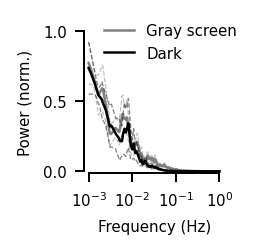

In [6]:
fig, ax = plt.subplots()

for condition, label in zip(conditions, labels):
    # Plot PSD for the given condition
    df = df_hht.query('condition == @condition')
    psd = np.row_stack(df['hht_psd'].values).mean(axis=0)  # mean across experiments
    ax.plot(np.log10(freqs), psd, color=COLORS[condition], lw=1, label=label)

    # Plot SE with thin dashed lines
    sem_plus = psd + sem(np.row_stack(df['hht_psd'].values), axis=0)
    sem_minus = psd - sem(np.row_stack(df['hht_psd'].values), axis=0)
    ax.plot(np.log10(freqs), sem_minus, color=COLORS[condition], lw=0.5, ls='--', alpha=0.5)
    ax.plot(np.log10(freqs), sem_plus, color=COLORS[condition], lw=0.5, ls='--', alpha=0.5)

# Format x-axis
ax.set_xticks(FREQUENCYTICKS)
ax.set_xticklabels(FREQUENCYTICKLABELS)
ax.set_xlim(left=-3.1)  # allow for a little gap between x and y axes
ax.set_xlabel('Frequency (Hz)')

# Format y-axis
ax.set_yticks([0, 0.5, 1])
ax.set_ylim(bottom=ax.get_yticks().min() - 0.01)  # allow for a little gap between x and y axes
ax.set_ylabel('Power (norm.)')

ax.legend(frameon=False, loc=(0.1, 0.75))
clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'psd_spontaneous_dark' + FIGSAVEFORMAT)

### Figure S1B
Quantification of running data.

In [7]:
# Load data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_run = load_data('ball', conditions).set_index(['m', 's', 'e'])

Loading:  ball_spontaneous.pkl
Loading:  ball_sparsenoise.pkl


#### Figure S1B1
Proportion of time spent running.

min: 0.11
max: 0.47
median: 0.27


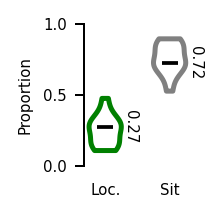

In [8]:
# Get proportion of total recording time spent running
df_run['run_prop'] = df_run.apply(lambda x: np.diff(x['run_bouts'], axis=1).sum() / (x['run_tpts'].max() - x['run_tpts'].min()), axis='columns')
df_run['sit_prop'] = df_run.apply(lambda x: np.diff(x['sit_bouts'], axis=1).sum() / (x['run_tpts'].max() - x['run_tpts'].min()), axis='columns')
print(f"min: {df_run['run_prop'].min():.2f}")
print(f"max: {df_run['run_prop'].max():.2f}")
print(f"median: {df_run['run_prop'].median():.2f}")

# Make violin plot
dists = [df_run['run_prop'], df_run['sit_prop']]
colors = [COLORS['run'], COLORS['sit']]
ax = violin_plot(dists, colors)  

# Format axes
ax.set_xticklabels(['Loc.', 'Sit'])
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Proportion')

clip_axes_to_ticks(ax=ax, spines=['left'])
set_plotsize(w=1.5, h=2)
fig = ax.get_figure()
fig.savefig(FIGUREPATH + 'run_prop' + FIGSAVEFORMAT)

#### Figure S1B2
Duration of periods of running and sitting.

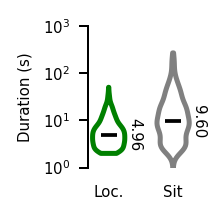

In [10]:
# Get lengths of all periods of running or sitting
df_run['run_bout_lengths'] = df_run['run_bouts'].apply(lambda x: x[:, 1] - x[:, 0])
df_run['sit_bout_lengths'] = df_run['sit_bouts'].apply(lambda x: x[:, 1] - x[:, 0])
bout_lengths = np.concatenate(df_run['run_bout_lengths'].values)
bout_intervals = np.concatenate(df_run['sit_bout_lengths'].values)

# Make violin plot
dists = [np.log10(bout_lengths), np.log10(bout_intervals)]
colors = [COLORS['run'], COLORS['sit']]
ax = violin_plot(dists, colors, logscale=True) 

# Format axes
ax.set_xticklabels(['Loc.', 'Sit'])
ax.tick_params(bottom=False)
ax.set_yticks(np.linspace(0, 3, 4))
ax.set_yticklabels("$10^{%d}$" % tick for tick in np.linspace(0, 3, 4))
ax.set_ylim(bottom=0)
ax.set_ylabel('Duration (s)')

clip_axes_to_ticks(ax=ax, spines=['left'])
set_plotsize(w=1.5, h=2)
fig = ax.get_figure()
fig.savefig(FIGUREPATH + 'run_bout_lengths' + FIGSAVEFORMAT)

#### Figure S1B3
Variance of locomotion speed during and in-between bouts.

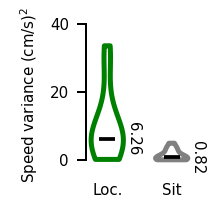

In [11]:
# Get locomotion speed data for each state (excluding onsets anf offsets)
kwargs = {'data':'run_speed', 'trange':'middle', 'concatenate':True}
df_run['run_speed_run'] = df_run.apply(take_data_in_bouts, bouts='run', **kwargs, axis='columns')
df_run['run_speed_sit'] = df_run.apply(take_data_in_bouts, bouts='sit', **kwargs, axis='columns')
# Get locomotion speed variance
var_run = df_run['run_speed_run'].apply(np.var)
var_sit = df_run['run_speed_sit'].apply(np.var)

# Make violin plot
dists = [var_run, var_sit]
colors = [COLORS['run'], COLORS['sit']]
ax = violin_plot(dists, colors) 

# Format axes
ax.set_xticklabels(['Loc.', 'Sit'])
ax.tick_params(bottom=False)
ax.set_yticks([0, 20, 40])
ax.set_ylabel('Speed variance (cm/s)$^2$')

clip_axes_to_ticks(ax=ax, spines=['left'])
set_plotsize(w=1.5, h=2)
fig = ax.get_figure()
fig.savefig(FIGUREPATH + 'run_speed_variance.svg')

### Figure S1B4
Pupil size change at locomotion bout onset and offsets.

In [12]:
conditions = ['spontaneous', 'sparsenoise']
df_run = load_data('ball', conditions)
df_pupil = load_data('pupil', conditions)
df = pd.merge(df_run, df_pupil, on=['m', 's', 'e']).set_index(['m', 's', 'e'])

dt = 0.1
df['pupil_tpts'], df['pupil_area'] = zip(*df.apply(lambda x: resample_timeseries(x['pupil_area'], x['pupil_tpts'], dt=dt), axis='columns'))
df['run_times'] = df.apply(lambda x: x['run_bouts'][:, 0], axis='columns')
df['sit_times'] = df.apply(lambda x: x['run_bouts'][:, 1], axis='columns')

Loading:  ball_spontaneous.pkl
Loading:  ball_sparsenoise.pkl
Loading:  pupil_spontaneous.pkl
Loading:  pupil_sparsenoise.pkl


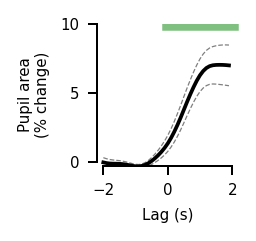

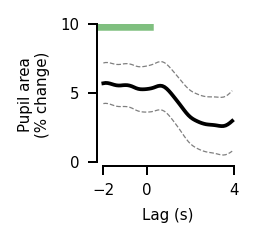

In [13]:
pre = {'run': 2, 'sit': 2}
post = {'run': 2, 'sit': 4}
baseline = {'run': [-2, 0], 'sit': [-2, 0]}

for state in ['run', 'sit']:
    fig, ax = plt.subplots()

    tpts = np.arange(-1 * pre[state], post[state], dt)
    kwargs = {'data':'pupil_area', 'events':state, 'pre':pre[state], 'post':post[state]}
    responses = np.row_stack(df.apply(apply_get_responses, **kwargs, axis='columns'))
    if state == 'run':
        bi0, bi1 = tpts.searchsorted(baseline[state])
        baselines = responses[:, bi0:bi1].mean(axis=1)
    responses = ((responses.T - baselines) / baselines * 100).T
    
    mean = np.nanmean(responses, axis=0)
    err = sem(responses, nan_policy='omit', axis=0)
    
    ax.plot(tpts, mean, color='black')
    ax.plot(tpts, mean + err, ls='--', lw=0.5, color='black', alpha=0.5)
    ax.plot(tpts, mean - err, ls='--', lw=0.5, color='black', alpha=0.5)
    
    if state == 'run':
        ax.plot([0, post[state]], [10, 10], lw=5, color=COLORS['run'], alpha=0.5)
    if state == 'sit':
        ax.plot([-1 * pre[state], 0], [10, 10], lw=5, color=COLORS['run'], alpha=0.5)
    
    ax.set_xticks([-1 * pre[state], 0, post[state]])
    ax.set_xlabel('Lag (s)')
    ax.set_yticks([0, 5, 10])
    ax.set_ylim(bottom=-0.25, top=10)
    ax.set_ylabel('Pupil area\n(% change)')
    
    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=2, h=2)
    fig.savefig(FIGUREPATH + f'{state}_triggered_pupil_area' + FIGSAVEFORMAT)

### Figure S1B5
Pupil size PSD during gray screen experiments and darkness experiments.

In [14]:
# Load data from gray screen and dark experiments
conditions = ['spontaneous', 'dark']
labels = ['Gray screen', 'Dark']
df_hht = load_data('hht', ['spontaneous', 'dark'])

# Set a common frequency space
freqs = np.logspace(-3, 0, 1000)

# Interpolate
df_hht['run_psd'] = df_hht.apply(lambda x: interpolate(x['run_psd'], x['psd_freq'], freqs), axis='columns')
df_hht['sit_psd'] = df_hht.apply(lambda x: interpolate(x['sit_psd'], x['psd_freq'], freqs), axis='columns')

Loading:  hht_spontaneous.pkl
Loading:  hht_dark.pkl


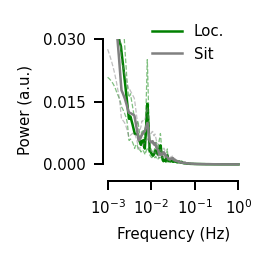

In [15]:
fig, ax = plt.subplots()
for state, label in zip(['run', 'sit'], ['Loc.', 'Sit']):
    # Plot PSD for the given condition
    psd = np.row_stack(df_hht['%s_psd' % state].values).mean(axis=0)  # mean across experiments
    ax.plot(np.log10(freqs), psd, color=COLORS[state], lw=1, label=label)

    # Plot SE with thin dashed lines
    sem_plus = psd + sem(np.row_stack(df_hht['%s_psd' % state].values), axis=0)
    sem_minus = psd - sem(np.row_stack(df_hht['%s_psd' % state].values), axis=0)
    ax.plot(np.log10(freqs), sem_minus, color=COLORS[state], lw=0.5, ls='--', alpha=0.5)
    ax.plot(np.log10(freqs), sem_plus, color=COLORS[state], lw=0.5, ls='--', alpha=0.5)

# Format x-axis
ax.set_xticks(FREQUENCYTICKS)
ax.set_xticklabels(FREQUENCYTICKLABELS)
ax.set_xlim(left=-3.1)  # allow for a little gap between x and y axes
ax.set_xlabel('Frequency (Hz)')

# Format y-axis
ax.set_yticks([0, 0.015, 0.03])
ax.set_ylim(top=0.03)  # allow for a little gap between x and y axes
ax.set_ylabel('Power (a.u.)')

ax.legend(frameon=False, loc=(0.3, 0.8))
clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'psd_run_sit' + FIGSAVEFORMAT)

### Figure S1C
Firing rates across pupil sizes in darkness.

Loading:  sizetuning_dark_spk.pkl
Monotonic increasing: 34/89 (38.2)


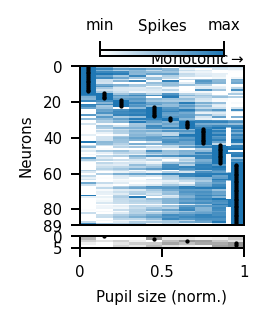

In [16]:
# Load pupil size tuning data for tonic spikes from dark experiments
conditions = ['dark']
df = load_data('sizetuning', conditions, spk_type='spk').set_index(['m', 's', 'e', 'u'])

# Get graded colormap for tonic spikes
toniccmap = LinearSegmentedColormap.from_list("toniccmap", ['white', np.array(to_rgba(COLORS['tonicspk']))])
# Plot rate heatmap
fig = pupil_area_rate_heatmap(df, toniccmap, max_rate='high')

set_plotsize(w=2.25, h=3)
fig.savefig(FIGUREPATH + 'pupil_size_spk_tuning_dark' + FIGSAVEFORMAT)

Loading:  sizetuning_dark_burst.pkl
Monotonic decreasing: 34/44 (77.3)


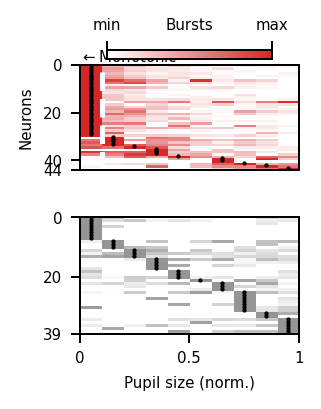

In [17]:
# Load pupil size tuning data for bursts from dark experiments
conditions = ['dark']
df = load_data('sizetuning', conditions, spk_type='burst').set_index(['m', 's', 'e', 'u'])

# Get graded colormap for tonic spikes
burstcmap = LinearSegmentedColormap.from_list("burstcmap", ['white', np.array(to_rgba(COLORS['burst']))])
# Plot rate heatmap with example
fig = pupil_area_rate_heatmap(df, burstcmap, max_rate='low', example=FIG1BEXAMPLEKEY)
# Change label from 'Spikes' to 'Bursts'
fig.axes[1].set_xlabel('Bursts')

set_plotsize(w=3, h=4)
fig.savefig(FIGUREPATH + 'pupil_size_burst_tuning_dark' + FIGSAVEFORMAT)

### Figure S1C2
Fano factor across pupil size bins in light and darkness.

In [20]:
# Load data from experiments with monitor on
conditions = ['spontaneous', 'sparsenoise']
df_light = load_data('sizetuning', conditions, spk_type='spk').set_index(['m', 's', 'e', 'u'])

# Load data from experiments in darkness
conditions = ['dark']
df_dark = load_data('sizetuning', conditions, spk_type='spk').set_index(['m', 's', 'e', 'u'])

# Compute Fano factor for each pupil size bin
df_light['area_fano'] = df_light.apply(lambda x: x['area_var'] / x['area_means'], axis='columns')
fano_light_matrix = np.row_stack(df_light['area_fano'])
df_dark['area_fano'] = df_dark.apply(lambda x: x['area_var'] / x['area_means'], axis='columns')
fano_dark_matrix = np.row_stack(df_dark['area_fano'])

# Test for Fano factor > 1
print("FF light > 1: w=%.3e, p=%.3e" % wilcoxon(np.nanmean(fano_light_matrix, axis=1) - 1, alternative='greater'))
print("FF dark > 1: w=%.3e, p=%.3e" % wilcoxon(np.nanmean(fano_dark_matrix, axis=1) - 1, alternative='greater'))

Loading:  sizetuning_spontaneous_spk.pkl
Loading:  sizetuning_sparsenoise_spk.pkl
Loading:  sizetuning_dark_spk.pkl
FF light > 1: w=1.205e+04, p=5.236e-26
FF dark > 1: w=4.353e+03, p=6.412e-16


/tmp/ipykernel_53774/4088828529.py:10: RuntimeWarning: invalid value encountered in divide
  df_light['area_fano'] = df_light.apply(lambda x: x['area_var'] / x['area_means'], axis='columns')
/tmp/ipykernel_53774/4088828529.py:12: RuntimeWarning: invalid value encountered in divide
  df_dark['area_fano'] = df_dark.apply(lambda x: x['area_var'] / x['area_means'], axis='columns')


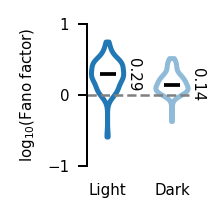

In [21]:
# Take mean Fano factor across pupil sizes
fano_light = np.nanmean(fano_light_matrix, axis=1)
fano_dark = np.nanmean(fano_dark_matrix, axis=1)

# Plot Fano factor distributions
dists = [np.log10(fano_light), np.log10(fano_dark)]  # log-transform fano factors
colors = [toniccmap(0.99), toniccmap(0.5)]
ax = violin_plot(dists, colors)
ax.axhline(0, color='gray', ls='--', lw=1)  # add line a FF = 1

# Format axes
ax.set_xticklabels(['Light', 'Dark'])
ax.set_yticks([-1, 0, 1,])
ax.set_ylabel('log$_{10}$(Fano factor)')

clip_axes_to_ticks(ax=ax, spines=['left'])
set_plotsize(w=1.5, h=2)
fig = ax.get_figure()
fig.savefig(FIGUREPATH + 'pupil_size_fano_dists' + FIGSAVEFORMAT)

### Figure S1D1
Schematic diagram for joint phase distributions.

/tmp/ipykernel_53774/3976392503.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x, y = np.random.multivariate_normal([-1, 0], [[2, 4], [4, 2]], 5000).T


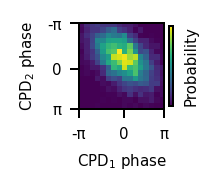

In [22]:
fig, ax = plt.subplots()

# Sample from some 2D distribution
x, y = np.random.multivariate_normal([-1, 0], [[2, 4], [4, 2]], 5000).T

# Plot 2D histogram as heatmap
H, _, _ = np.histogram2d(x, y, bins=np.linspace(-5, 5, 17))
mat = ax.imshow(H)

# Add a colorbar
cax = plt.colorbar(mat, ax=ax, label='Probability', shrink=0.75)
cax.ax.set_yticks([])

# Format x-axis
ax.set_xticks([-0.5, 8, 15.5])
ax.set_xticklabels(['-'+u'\u03C0', 0, u'\u03C0'])
ax.set_xlabel("CPD$_1$ phase")

# Format y-axis
ax.set_yticks([-0.5, 8, 15.5])
ax.set_yticklabels(['-'+u'\u03C0', 0, u'\u03C0'])
ax.set_ylabel("CPD$_2$ phase")

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'imf_sync_example' + FIGSAVEFORMAT)

### Figure S1D2
Phase couping analysis for the example IMFs from Figure 1D.

In [26]:
# Load pupil size data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_pupil = load_data('pupil', conditions).set_index(['m', 's', 'e'])

# Get pupil size data for example experiment (same as Figure 1B)
key = FIG1BEXAMPLEKEY
idx = key2idx(key)[:-1]
pupil_area = df_pupil.loc[idx]['pupil_area']
pupil_tpts = df_pupil.loc[idx]['pupil_tpts']
pupil_fs = 1 / np.diff(pupil_tpts).mean()

# Apply Hilbert-Huang transform to example pupil size trace
hht = HHT(pupil_area, pupil_fs)  # instantiate transform object
hht.emd()  # empirical mode decomposition
hht.hsa()  # Hilbert spectral analysis
hht.check_number_of_phasebin_visits(remove_invalid=True)  # remove IMFs with fewer than 4 complete cycles

# Perform phase coupling analysis on joint phase distributions for all IMF pairs
# DD: joint phase distributions, masks: regions in joint distribution with p <= 0.05
# (i.e. the combination of phases that occur more than would be expected by chance)
# ranges: time ranges in which the two IMFs pass through significant in phase-phase space
DD, _, DD_p, DD_masks, DD_ranges = hht.phase_synchrony()

Loading:  pupil_spontaneous.pkl
Loading:  pupil_sparsenoise.pkl


/home/crombie/code/imftuning_code/util.py:661: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/home/crombie/code/imftuning_code/util.py:661: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


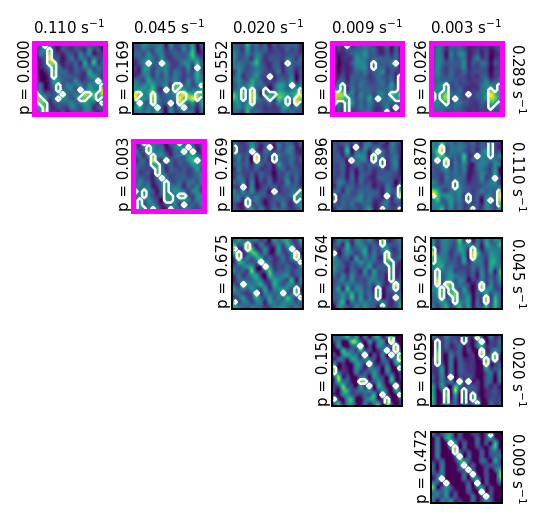

In [27]:
fig, axs = plt.subplots(DD.shape[0], DD.shape[1])

# Loop over joint phase distributions of all IMF pairs
for i in range(DD.shape[0]):
    for j in range(DD.shape[1]):
        # Set IMF label
        if i == 0: # Top
            axs[i, j].xaxis.set_label_position('top')
            axs[i, j].set_xlabel('%.3f s$^{-1}$' % hht.characteristic_frequency[j], fontsize=LABELFONTSIZE)
        if j == (len(DD) - 1): # Right
            axs[i, j].yaxis.set_label_position('right')
            axs[i, j].set_ylabel('%.3f s$^{-1}$' % hht.characteristic_frequency[i], rotation=270, labelpad=10, fontsize=LABELFONTSIZE)
        # Plot only the upper triangle
        if i < j:
            # Remove ticks and labels
            axs[i, j].tick_params(left=False)
            axs[i, j].set_yticklabels([])
            axs[i, j].matshow(DD[i, j], interpolation='spline16')
            axs[i, j].contour(DD_masks[i, j], levels=[0.5], linewidths=1, colors='white')
            axs[i, j].set_xticks([])
            axs[i, j].text(-0.225, 0.05, f'p = {DD_p[i, j]:.3f}', rotation=90, fontsize=LABELFONTSIZE, transform=axs[i, j].transAxes)
            if DD_p[i, j] <= 0.05:
                for spine in axs[i, j].spines.values():
                        spine.set_edgecolor('magenta')
                        spine.set_linewidth(2)
        else:
            axs[i, j].remove()
fig.subplots_adjust(wspace=0.4)
set_plotsize(w=8, h=8)
fig.savefig(FIGUREPATH + 'imf_phase_coupling' + FIGSAVEFORMAT)

In [28]:
# Load HHT data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_hht = load_data('hht', conditions).set_index(['m', 's', 'e'])

# Collect IMF pair frequencies and correlations for all decompositions
x_freqs = np.array([])
y_freqs = np.array([]) 
klds = np.array([])
sig = np.array([], dtype='bool')  # whether joint distribution has p <= 0.05
# Loop over all decompositions
for idx, row in df_hht.iterrows():
    # Get Kullback-Leibler divergence comparing joint phase distribution to uniform for all IMF pairs in decomposition
    # expressed as z-score relative to the KLDs of 1000 joint distibutions from cycle-shuffled IMFs
    kld = row['sync_kld']
    p = row['sync_p']  # p-value of actual KLD relative to shuffle distribution
    # Get IMF frequencies
    freq = row['frequency']
    # Get index grid
    x_inds, y_inds = np.meshgrid(np.arange(len(kld)), np.arange(len(kld)))
    # Use grid indices to get frequencies for IMF pairs (then flatten arrays and concatenate to group)
    x_freqs = np.append(x_freqs, freq[x_inds].ravel())
    y_freqs = np.append(y_freqs, freq[y_inds].ravel())
    # Flatten correlation matrix and concatenate to group data
    klds = np.append(klds, kld.ravel())
    sig = np.append(sig, p.ravel() <= 0.05)
# Log-transform frequencies
x_freqs = np.log10(x_freqs)
y_freqs = np.log10(y_freqs)

print(f"Coupled CPDs: {sig.mean() * 100:.1f}")

Loading:  hht_spontaneous.pkl
Loading:  hht_sparsenoise.pkl
Coupled CPDs: 23.0


No significant coupling: 354 IMFs
Significant coupling: 106 IMFs


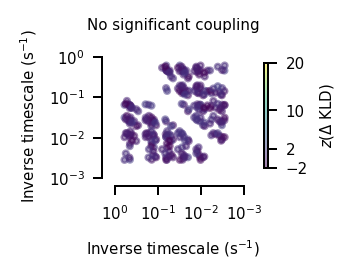

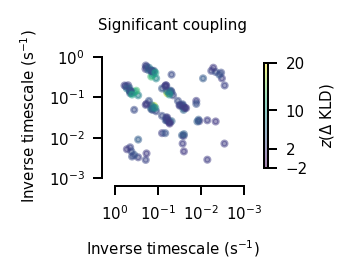

In [29]:
# Make the same plot for IMF pairs with and without significant phase coupling
for label, imf_pairs_to_plot in zip(['ns', 'sig'], [~sig, sig]):
    fig, ax  = plt.subplots()
    # Freq-freq scatter plot of IMF pairs, KLD z-score is indicated by color
    im = ax.scatter(x_freqs[imf_pairs_to_plot], y_freqs[imf_pairs_to_plot], c=klds[imf_pairs_to_plot], 
                    cmap='viridis', vmin=-2, vmax=20, s=5, alpha=0.5)

    # Set frequency ticks and labels
    freqticks = np.arange(-3, 1)
    freqticklabels = ['10$^{%d}$' % tick for tick in freqticks]
    ax.set_xticks(freqticks)
    ax.set_xticklabels(freqticklabels)
    ax.set_xlim(right=0.3)
    ax.invert_xaxis()
    ax.set_yticks(freqticks)
    ax.set_yticklabels(freqticklabels)
    ax.set_ylim(top=0.3, bottom=-3.2)
    ax.set_xlabel('Inverse timescale (s$^{-1}$)', labelpad=6)
    ax.set_ylabel('Inverse timescale (s$^{-1}$)')
    
    # Make colorbar for KLD z-scores
    bbox = ax.get_position()
    cax = fig.add_axes([bbox.x1, bbox.y0 + 0.1, 0.02, bbox.height - 0.2])
    cbar = fig.colorbar(im, cax=cax, ticks=[-2, 2, 10, 20])
    cbar.ax.set_ylabel('$z$($\Delta$ KLD)')

    # Make title and print number of IMF pairs plotted
    if label == 'ns':
        print(f'No significant coupling: {sum(imf_pairs_to_plot)} IMFs')
        ax.set_title('No significant coupling', fontsize=LABELFONTSIZE)
    elif label == 'sig':
        print(f'Significant coupling: {sum(imf_pairs_to_plot)} IMFs')
        ax.set_title('Significant coupling', fontsize=LABELFONTSIZE)
    
    clip_axes_to_ticks(ax=ax, spines=['left', 'bottom'])
    fig.subplots_adjust(left=0.1, right=0.8)
    set_plotsize(w=2, h=2, ax=ax)
    fig.savefig(FIGUREPATH + f'imf_phase_coupling_scatter_{label}' + FIGSAVEFORMAT)

### Fig S2
Firing rate distributions and correlograms.

In [30]:
# Load spike data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_spikes = load_data('spikes', conditions)
# Load pupil data as well and merge dataframes so that we only look at neurons that have accompanying eye tracking data
df_pupil = load_data('pupil', conditions)
df_spikes = pd.merge(df_spikes, df_pupil).set_index(['m', 's', 'e', 'u'])
df_spikes = filter_units(df_spikes, MINRATE)  # remove units with suspiciously low firing rates

Loading:  spikes_spontaneous.pkl
Loading:  spikes_sparsenoise.pkl
Loading:  pupil_spontaneous.pkl
Loading:  pupil_sparsenoise.pkl


#### Figure S2A1
Mean firing rate and mean tonic spike rate distributions.

Mean spk rate: 4.49 (N = 156)
Mean tonicspk rate: 4.11 (N = 156)


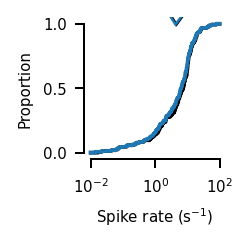

In [31]:
# Get mean overall firing rate ('spk'), and mean rate only including tonic spikes (i.e. after eliminating spikes that are part of a burst)
df_spikes['length'] = df_spikes['spk_tinfo'].apply(lambda x: x[1] - x[0])
for spk_type in ['spk', 'tonicspk']:
    df_spikes[f'{spk_type}_rate'] = df_spikes.apply(lambda x: len(x[f'{spk_type}_times']) / x['length'], axis='columns')

# Get histogram bins (log rate)
rate_bins = np.linspace(-2, 2, 1000)

# Plot rate histograms for each spike type
fig, ax = plt.subplots()
for spk_type in ['spk', 'tonicspk']:
    # Pull mean rates from data frame, log transform
    rates = np.log10(df_spikes[f'{spk_type}_rate'])
    print(f"Mean {spk_type} rate: {10 ** rates.mean():.2f} (N = {len(rates)})")
    # Plot cumulative histogram
    cumulative_histogram(rates, rate_bins, color=COLORS[spk_type], ax=ax)
    # Add marker for mean rate to top of plot
    ax.plot(rates.mean(), 1, marker=7, color=COLORS[spk_type], fillstyle='none')

# Format axes
ax.set_xticks([-2, 0, 2])
ax.set_xticklabels(['$10^{%d}$' % tick for tick in [-2, 0, 2]])
ax.set_xlabel("Spike rate (s$^{-1}$)")
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Proportion')

clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'rate_distributions' + FIGSAVEFORMAT)

#### Figure S1A2
Burst ratio distribution.

Median burst ratio: 3.03e-02 (3.26e-05, 6.65e-01)
N = 145


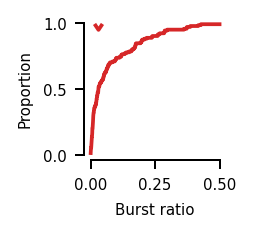

In [32]:
# Get burst ratio (proportion of all spikes that are part of a burst)
df_spikes['burst_ratio'] = df_spikes.apply(lambda x: len(x['burstspk_times']) / len(x['spk_times']), axis='columns')
ratios = df_spikes.query('burst_ratio > 0')['burst_ratio']  # only include neurons that have bursts
ratio_bins = np.linspace(0, 0.5, 1000)

# Plot burst ratio distribution as cumulative distribution
fig, ax = plt.subplots()
cumulative_histogram(ratios, ratio_bins, color=COLORS['burst'], ax=ax) 

# Add marker for median burst ratio at top of plot
print(f"Median burst ratio: {np.median(ratios):.2e} ({ratios.min():.2e}, {ratios.max():.2e})")
ax.scatter(np.median(ratios), 0.95, marker=7, s=10, ec=COLORS['burst'], fc='none')
print(f'N = {len(ratios)}')

# Format axes
ax.set_xticks([0, 0.25, 0.5])
ax.set_xlabel('Burst ratio')
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Proportion')

clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'burst_ratio_distribution' + FIGSAVEFORMAT)

#### Figure S2B1
Mean auto-correlogram of tonic spiking.

In [33]:
# Get auto-correlogram for tonic spikes
df_spikes['tonicspk_acg'] = df_spikes['tonicspk_times'].apply(correlogram)

/home/crombie/code/imftuning_code/util.py:574: RuntimeWarning: divide by zero encountered in divide
  ccg /= len(ts1)
/home/crombie/code/imftuning_code/util.py:574: RuntimeWarning: invalid value encountered in divide
  ccg /= len(ts1)


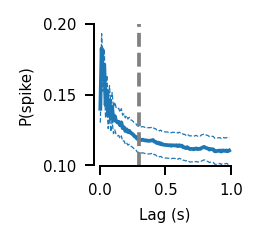

In [34]:
# Get mean ACG and SE from dataframe
tonicspk_acg = df_spikes['tonicspk_acg'].values.mean(axis=0)
tonicspk_sem = sem(df_spikes['tonicspk_acg'].values, axis=0)
tpts, _ = correlogram(np.array([]), return_tpts=True)  # get lags

# Plot mean ACG and SE
fig, ax = plt.subplots()
ax.plot(tpts[tpts >= 0], tonicspk_acg[tpts >= 0], color=COLORS['tonicspk'])
ax.plot(tpts[tpts >= 0], tonicspk_acg[tpts >= 0] - tonicspk_sem[tpts >= 0], color=COLORS['tonicspk'], lw=0.5, ls='--')
ax.plot(tpts[tpts >= 0], tonicspk_acg[tpts >= 0] + tonicspk_sem[tpts >= 0], color=COLORS['tonicspk'], lw=0.5, ls='--')

# Add dashed line at 300ms (peak prior to this value indicates presence of short timescale structure)
ax.axvline(0.3, ls='--', color='gray')

# Format axes
ax.set_xticks([0, 0.5, 1])
ax.set_xlabel("Lag (s)")
ax.set_yticks([0.1, 0.15, 0.2])
ax.set_ylim(bottom=0.1)
ax.set_ylabel("P(spike)")

clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'tonicspk_acg' + FIGSAVEFORMAT)

#### Figure S2B1
Mean auto-correlogram of bursts.

In [35]:
# Get auto-correlogram for bursts
df_bursts = df_spikes.query('burst_times.str.len() > 0')  # only consider neurons with bursts
df_bursts['burst_acg'] = df_bursts['burst_times'].apply(correlogram)

/tmp/ipykernel_53774/3371122251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bursts['burst_acg'] = df_bursts['burst_times'].apply(correlogram)


/home/crombie/code/imftuning_code/util.py:574: RuntimeWarning: divide by zero encountered in divide
  ccg /= len(ts1)
/home/crombie/code/imftuning_code/util.py:574: RuntimeWarning: invalid value encountered in divide
  ccg /= len(ts1)


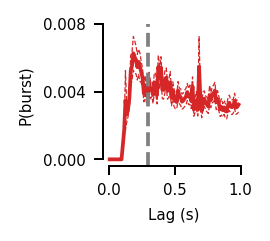

In [36]:
# Get mean ACG and SE from dataframe
burst_acg = df_bursts['burst_acg'].values.mean(axis=0)
burst_sem = sem(df_bursts['burst_acg'].values, axis=0)
tpts, _ = correlogram(np.array([]), return_tpts=True)  # get lags

# Plot mean ACG and SE
fig, ax = plt.subplots()
ax.plot(tpts[tpts >= 0], burst_acg[tpts >= 0], color=COLORS['burst'])
ax.plot(tpts[tpts >= 0], burst_acg[tpts >= 0] - burst_sem[tpts >= 0], color=COLORS['burst'], lw=0.5, ls='--')
ax.plot(tpts[tpts >= 0], burst_acg[tpts >= 0] + burst_sem[tpts >= 0], color=COLORS['burst'], lw=0.5, ls='--')

# Add dashed line at 300ms (peak prior to this value indicates presence of short timescale structure)
ax.axvline(0.3, ls='--', color='gray')

# Format axes
ax.set_xticks([0, 0.5, 1])
ax.set_xlabel("Lag (s)")
ax.set_yticks([0, 0.004, 0.008])
ax.set_ylabel("P(burst)")

clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'burst_acg' + FIGSAVEFORMAT)

#### Figure S2C
Mean burst cross-correlogram

In [37]:
ccgs = []
# Loop over recordings
for idx, group in df_spikes.groupby(['m', 's', 'e']):
    # Loop over unit pairs
    for u1 in range(len(group)):
        for u2 in range(len(group)):
            if u1 >= u2: continue
            # Compute cross-correlogram
            bt1 = group.iloc[u1]['burst_times']
            bt2 = group.iloc[u2]['burst_times']
            tpts, ccg = correlogram(bt1, bt2, tau_max=0.5, return_tpts=True)
            ccgs.append(ccg[tpts >= 0])

/home/crombie/code/imftuning_code/util.py:574: RuntimeWarning: divide by zero encountered in divide
  ccg /= len(ts1)
/home/crombie/code/imftuning_code/util.py:574: RuntimeWarning: invalid value encountered in divide
  ccg /= len(ts1)


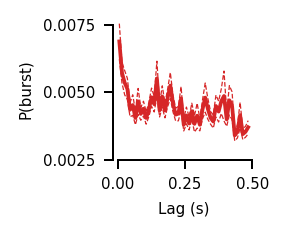

In [38]:
# Get mean CCG and SE
mean = np.nanmean(np.row_stack(ccgs), axis=0)
se = sem(np.row_stack(ccgs), axis=0, nan_policy='omit')

# Plot mean CCG and SE
fig, ax = plt.subplots()
ax.plot(tpts[tpts >= 0], mean, color=COLORS['burst'])
ax.plot(tpts[tpts >= 0], mean - se, color=COLORS['burst'], lw=0.5, ls='--')
ax.plot(tpts[tpts >= 0], mean + se, color=COLORS['burst'], lw=0.5, ls='--')

# Format axes
ax.set_xticks([0, 0.25, 0.5])
ax.set_xlabel("Lag (s)")
ax.set_yticks([0.0025, 0.005, 0.0075])
ax.set_ylabel("P(burst)")

clip_axes_to_ticks(ax=ax)
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'burst_ccg' + FIGSAVEFORMAT)

### Figure S3A
Phase couplng measured in darkness.

In [39]:
# Load spike data from dark experiments
df = load_data('phasetuning', ['spontaneous', 'sparsenoise'])
df_dark = load_data('phasetuning', ['dark'])

# Assign significance based on p-value from shuffled permutation test
df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05
df_dark['tonicspk_sig'] = df_dark['tonicspk_p'] <= 0.05
df_dark['burst_sig'] = df_dark['burst_p'] <= 0.05

# Print a summary of coupling across the population of neurons
coupling_summary(df_dark)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl
Loading:  phasetuning_dark.pkl
Neurons with significant coupling: 0.968 (91/94)
Tonicspk prop. significant: 0.968 (91/94)
Tonicspk num. CPDs per neuron: 3.41, 1.46
Burst prop. significant: 0.648 (35/54)
Burst num. CPDs per neuron: 1.85, 1.73


#### Figure S3A1

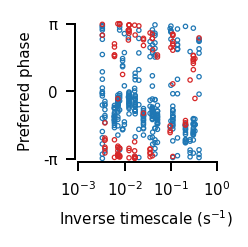

In [40]:
# Make phase-frequency scatter plot
fig, ax = plt.subplots()
ax = phase_coupling_scatter(df_dark, ax=ax)

set_plotsize(w=2, h=2)
clip_axes_to_ticks(ax=ax)
fig.savefig(FIGUREPATH + 'phase_coupling_scatter_dark' + FIGSAVEFORMAT)

#### Figure S3A2
Burst-tonic phase difference distribution for phase coupling measured in darkness.

Dark mean: 2.522758801418326
V 2.58e+01, p 5.12e-05
N = 88


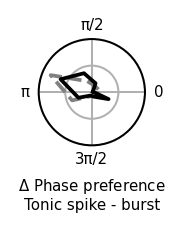

In [41]:
bins = np.linspace(0, 2 * np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})

# Plot the circular distribution for burst-tonic spike phase differences with the display monitor on
df_sig_light = df.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_light = (df_sig_light['tonicspk_phase'] - df_sig_light['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_light, bins=bins, ax=ax, color='gray', ls='--')

# Plot the circular distribution for burst-tonic spike phase differences in darkness
df_sig_dark = df_dark.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_dark = (df_sig_dark['tonicspk_phase'] - df_sig_dark['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_dark, bins=bins, ax=ax, color='black')

# V-test for non-uniformity and mean of pi
p, v = vtest(phase_diff_dark, np.pi)
print(f'Dark mean: {circmean_angle(phase_diff_dark)}')
print(f"V {v:.2e}, p {p:.2e}")
print(f"N = {len(phase_diff_dark)}")

# Format axes
ax.set_xlabel('$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])
ax.set_ylim(top=0.5)

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_diff_circhist_dark' + FIGSAVEFORMAT)

Tonicspk light median: 0.0081, N: 682
Tonicspk dark median: 0.0058, N: 321
Light vs dark: U=1.222e+05, p=2.945e-03
Burst light median: 0.0528, N: 320
Burst dark median: 0.0386, N: 100
Light vs dark: U=1.806e+04, p=5.227e-02
Burst vs tonic: W=5.800e+01, p=2.666e-15
N = 88 CPD-neuron pairs


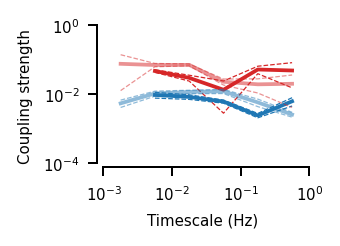

In [43]:
# Plot median coupling strengths and SE across timescale bins
fig, ax = plt.subplots()
ax = coupling_strength_line_plot(df_dark, agg=np.median, err=se_median, ax=ax)
ax = coupling_strength_line_plot(df, agg=np.median, err=se_median, ax=ax, alpha=0.5)

# For each spike type compare overall coupling strengths between conditions
for spk_type in ['tonicspk', 'burst']:
    strengths_light = df.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    strengths_dark = df_dark.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    print(f'{spk_type.capitalize()} light median: {strengths_light.median():.4f}, N: {len(strengths_light)}')
    print(f'{spk_type.capitalize()} dark median: {strengths_dark.median():.4f}, N: {len(strengths_dark)}')
    U, p = mannwhitneyu(strengths_light, strengths_dark)
    print(f"Light vs dark: U={U:.3e}, p={p:.3e}")

# Compare burst and tonic spike strengths for coupling in darkness
df_sig = df_dark.query('(tonicspk_sig == True) & (burst_sig == True)')
W, p = wilcoxon(df_sig['burst_strength'], df_sig['tonicspk_strength'])
print(f"Burst vs tonic: W={W:.3e}, p={p:.3e}")
print(f"N = {len(df_sig)} CPD-neuron pairs")

# Format y-axis
yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['10$^{%d}$' % tick for tick in yticks])
ax.set_ylim(bottom=-4.1)

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'coupling_strength_dark' + FIGSAVEFORMAT)

### Figure S3B
Phase coupling measured after removal of phase combinations where IMFs are coupled (from analysis in Figure S1D)

In [44]:
# Load spike data from gray screen and sparsenoise experiments
# 'desync': coupling measured only after removal of periods in which
# the IMF couples to other IMFs in the recording ('desync')
conditions = ['spontaneous', 'sparsenoise']
df = load_data('phasetuning', conditions)
df_desync = load_data('phasetuning', conditions, subsample='desync')

# Assign significance based on p-value from shuffled permutation test
df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05
df_desync['tonicspk_sig'] = df_desync['tonicspk_p'] <= 0.05
df_desync['burst_sig'] = df_desync['burst_p'] <= 0.05

coupling_summary(df_desync)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl
Loading:  phasetuning_spontaneous_desync.pkl
Loading:  phasetuning_sparsenoise_desync.pkl
Neurons with significant coupling: 0.986 (146/148)
Tonicspk prop. significant: 0.980 (145/148)
Tonicspk num. CPDs per neuron: 3.80, 1.57
Burst prop. significant: 0.742 (89/120)
Burst num. CPDs per neuron: 2.08, 1.71


#### Figure S3B1

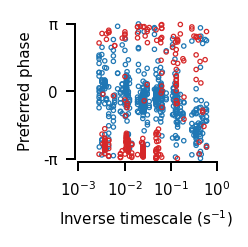

In [45]:
# Make phase-frequency scatter plot
fig, ax = plt.subplots()
ax = phase_coupling_scatter(df_desync, ax=ax)
set_plotsize(w=2, h=2)

clip_axes_to_ticks(ax=ax)
fig.savefig(FIGUREPATH + 'phase_coupling_scatter_desync' + FIGSAVEFORMAT)

Desync mean: 2.661021493637446
V 1.091e+02, p 0.000e+00
N = 203


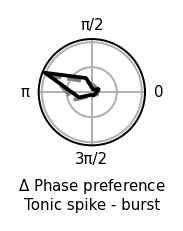

In [46]:
bins = np.linspace(0, 2 * np.pi, 9)
fig, ax = plt.subplots(subplot_kw={'polar':True})

# Plot the circular distribution for burst-tonic spike phase differences
df_sig = df.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff = (df_sig['tonicspk_phase'] - df_sig['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff, bins=bins, ax=ax, color='gray', ls='--')

# Plot the circular distribution for burst-tonic spike phase differences in 'desync' periods
df_sig_desync = df_desync.query('(tonicspk_sig == True) & (burst_sig == True)')
phase_diff_desync = (df_sig_desync['tonicspk_phase'] - df_sig_desync['burst_phase']) % (2 * np.pi)
ax, counts = plot_circhist(phase_diff_desync, bins=bins, ax=ax, color='black')

# V-test for non-uniformity and mean of pi
p, v = vtest(phase_diff_desync, np.pi)
print(f'Desync mean: {circmean_angle(phase_diff_desync)}')
print(f"V {v:.3e}, p {p:.3e}")
print(f"N = {len(phase_diff_desync)}")

# Format axes
ax.set_xlabel(r'$\Delta$ Phase preference' + '\nTonic spike - burst')
ax.set_yticks([0.25, 0.5])
ax.set_yticklabels([])

set_plotsize(w=1.5, h=1.5)
fig.savefig(FIGUREPATH + 'phase_diff_circhist_desync' + FIGSAVEFORMAT)

Tonicspk median: 0.0081, N: 682
Tonicspk desync median: 0.0089, N: 563
All periods vs desync: U=1.860e+05, p=3.419e-01
Burst median: 0.0528, N: 320
Burst desync median: 0.0583, N: 250
All periods vs desync: U=3.885e+04, p=5.568e-01
Burst vs tonic: W=1.699e+03, p=5.336e-25
N = 203 CPD-neuron pairs


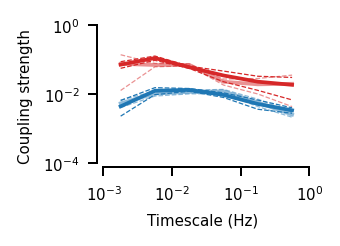

In [48]:
# Plot median coupling strengths and SE across timescale bins
fig, ax = plt.subplots()
ax = coupling_strength_line_plot(df_desync, agg=np.median, err=se_median, ax=ax)
ax = coupling_strength_line_plot(df, agg=np.median, err=se_median, ax=ax, alpha=0.5)

# For each spike type compare overall coupling strengths between conditions
for spk_type in ['tonicspk', 'burst']:
    strengths = df.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    strengths_desync = df_desync.query(f'{spk_type}_sig == True')[f'{spk_type}_strength']
    print(f'{spk_type.capitalize()} median: {strengths.median():.4f}, N: {len(strengths)}')
    print(f'{spk_type.capitalize()} desync median: {strengths_desync.median():.4f}, N: {len(strengths_desync)}')
    U, p = mannwhitneyu(strengths, strengths_desync)
    print(f"All periods vs desync: U={U:.3e}, p={p:.3e}")

# Compare burst and tonic spike strengths for coupling in 'desync' periods
df_sig = df_desync.query('(tonicspk_sig == True) & (burst_sig == True)')
W, p = wilcoxon(df_sig['burst_strength'], df_sig['tonicspk_strength'])
print(f"Burst vs tonic: W={W:.3e}, p={p:.3e}")
print(f"N = {len(df_sig)} CPD-neuron pairs")

# Format y-axis
yticks = [-4, -2, 0]
ax.set_yticks(yticks)
ax.set_yticklabels(['10$^{%d}$' % tick for tick in yticks])
ax.set_ylim(bottom=-4.1)

clip_axes_to_ticks(ax=ax)
set_plotsize(w=3, h=2)
fig.savefig(FIGUREPATH + 'coupling_strength_desync' + FIGSAVEFORMAT)

### Figure S3C2
Distance (index) between CPD with strongest coupling and CPD with second strongest coupling for each neuron.

In [49]:
# First, print the mean number of IMFs to which a neuron was coupled for each spike type
for spk_type in ['tonicspk', 'burst']:
    # Remove neurons where no coupling analysis was done, group data into neurons, count number of significant entries
    n_imfs = df_desync.dropna(subset=f'{spk_type}_p').groupby(['m', 's', 'e', 'u']).apply(lambda unit: unit[f'{spk_type}_sig'].sum())
    print(f"{spk_type.capitalize()} mean no. timescales: {n_imfs.mean():.2f}")

Tonicspk mean no. timescales: 3.80
Burst mean no. timescales: 2.08


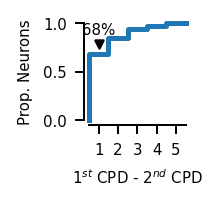

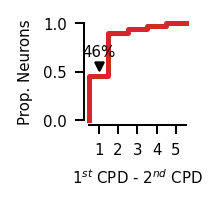

In [50]:
for spk_type in ['tonicspk', 'burst']:
    fig, ax = plt.subplots()
    # Use 'desync' coupling as adjacent IMFs tend to have phase relationships that could
    # drive strong coupling to adjacent timescales
    units = df_desync.query(f'{spk_type}_p == {spk_type}_p').groupby(['m', 's', 'e', 'u'])
    # Collect indices of IMFs with stongest and second strongest coupling for each neuron
    i1s, i2s = [], []
    for idx, unit in units:
        # Only consider neuron if it has significatn coupling with at least 2 IMFs for the given spike type
        if (unit[f'{spk_type}_sig']).sum() < 2:
            continue
        i1s.append(unit[f'{spk_type}_strength'].argsort().iloc[-1])
        i2s.append(unit[f'{spk_type}_strength'].argsort().iloc[-2])

    # Get index difference between two strongest IMFs for each unit
    diffs = np.abs(np.array(i1s) - np.array(i2s))

    # Plot distribution of differences as cumulative histogram
    ax, counts = cumulative_hist(diffs, np.linspace(0.5, 5.5, 6), ax=ax, color=COLORS[spk_type])
    
    # Label for the proportion of neurons where the difference is 1
    # (i.e. two strongest IMFs are adjacent in freq space)
    ax.scatter(1, np.sum(counts[:1]) + 0.1, s=10, marker='v', color='black')
    ax.text(1, np.sum(counts[:1]) + 0.2, f'{100 * np.sum(counts[:1]):.0f}%', ha='center', fontsize=LABELFONTSIZE)
    
    # Format axes
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlim(left=0.25)
    ax.set_xlabel('$1^{st}$ CPD - $2^{nd}$ CPD')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel('Prop. Neurons')
    
    clip_axes_to_ticks(ax=ax, ext={'bottom':[-0.5, 0.5]})
    set_plotsize(w=1.5, h=1.5)
    fig.savefig(FIGUREPATH + f'preferred_timescale_{spk_type}' + FIGSAVEFORMAT)

### Figure S3C1
Correlation between the frequency of switches between locomotor states and the most common strongest coupling CPD in an experiment.

In [51]:
df_run = load_data('ball', conditions).set_index(['m', 's', 'e'])
# State switches marked by onset and offset times of locomotion bouts, unravel and take difference gives dt, 1/dt gives frequency,
# log transform to match IMF frequency
state_variability = df_run.apply(lambda x: np.log10(1 / np.diff(x['run_bouts'].ravel()).mean()), axis='columns')

Loading:  ball_spontaneous.pkl
Loading:  ball_sparsenoise.pkl


tonicspk correlation: r=0.712, p=4.290e-03
burst correlation: r=-0.298, p=3.007e-01


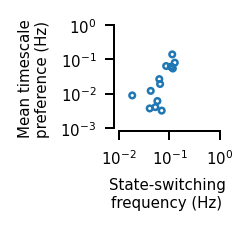

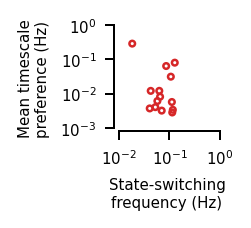

In [52]:
for spk_type in ['tonicspk', 'burst']:
    # Get IMF with strongest coupling for each neuron
    units = df.groupby(['m', 's', 'e', 'u'])
    pref_timescale = units.apply(lambda x: x['freq'].iloc[np.argmax(x[f'{spk_type}_strength'])])
    # Get the distribution of strongest coupling timescales for each recording session
    sessions = pref_timescale.groupby(['m', 's', 'e'])
    modes = np.log10(sessions.apply(lambda x: mode(x)[0]))  # mode of each distribution (in 1/s), log-transformed
    df_state = pd.merge(state_variability.rename('switch'), modes.rename('freq'), on=['m', 's', 'e'])
    r, p = pearsonr(df_state['switch'], df_state['freq'])
    print(f'{spk_type} correlation: r={r:.3f}, p={p:.3e}')

    # Scatter preferred timescale mode vs frequency of state switches
    fig, ax = plt.subplots()
    ax.scatter(df_state['switch'], df_state['freq'], s=5, fc='none', ec=COLORS[spk_type])

    # Format axes
    ax.set_xticks(np.log10(FREQUENCYBINS)[2::2])
    ax.set_xticklabels(FREQUENCYTICKLABELS[1:])
    ax.set_xlim(left=-2.1)
    ax.set_xlabel('State-switching\nfrequency (Hz)')
    ax.set_yticks(np.log10(FREQUENCYBINS)[::2])
    ax.set_yticklabels(FREQUENCYTICKLABELS)
    ax.set_ylabel("Mean timescale\npreference (Hz)")
    ax.set_ylim(bottom=-3.1)
    
    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=1.5, h=1.5, ax=ax)
    fig.savefig(FIGUREPATH + f'timescale_prefs_{spk_type}_behav_corr' + FIGSAVEFORMAT)

### Figure S3D1
Difference in coupling phase for all neuron-CPD pairs across interleaved data partitions to help show stability of coupling.

In [53]:
conditions = ['spontaneous', 'sparsenoise']
subsamples = ['split1', 'split2']

dfs = {}
for sub in subsamples:
    df = load_data('phasetuning', conditions, subsample=sub)
    df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
    df['burst_sig'] = df['burst_p'] <= 0.05
    df = df.set_index(['m', 's', 'e', 'u', 'imf']).sort_index()
    dfs[sub] = df
suffixes = ['_' + sub for sub in subsamples]
df = pd.merge(dfs['split1'], dfs['split2'], left_index=True, right_index=True, suffixes=suffixes)

freqbins = np.logspace(-3, 0, 7)
df['freq_bin'] = np.digitize(df['freq_split1'], bins=freqbins).clip(1, len(freqbins) - 1) - 1

for sub in subsamples:
    for spk_type in ['tonicspk', 'burst']:
        n_units = len(df.dropna(subset=f'{spk_type}_p_{sub}').reset_index(level='imf').index.unique())
        n_sig = len(df.query(f'{spk_type}_sig_{sub} == True').reset_index(level='imf').index.unique())
        print(f"{sub} {spk_type} significant: {(n_sig / n_units):.3f} ({n_sig}/{n_units})")

Loading:  phasetuning_spontaneous_split1.pkl
Loading:  phasetuning_sparsenoise_split1.pkl
Loading:  phasetuning_spontaneous_split2.pkl
Loading:  phasetuning_sparsenoise_split2.pkl
split1 tonicspk significant: 0.949 (148/156)
split1 burst significant: 0.746 (91/122)
split2 tonicspk significant: 0.968 (151/156)
split2 burst significant: 0.750 (90/120)


N IMFs tonicspk: 0.768
tonicspk diff: 0.13
0.9391480730223124
N IMFs burst: 0.812
burst diff: -0.10
0.9529411764705882


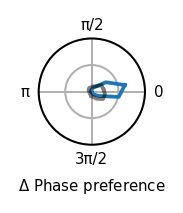

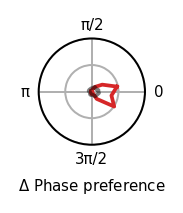

In [54]:
def compare_phase_preferences(df, conds, spk_type):
    df_sig = df.query(f'({spk_type}_sig_{conds[0]} == True) & ({spk_type}_sig_{conds[1]} == True)')
    angle_diffs_sig = (df_sig[f'{spk_type}_phase_{conds[0]}'] - df_sig[f'{spk_type}_phase_{conds[1]}']) % (2 * np.pi)
    ax, counts = plot_circhist(angle_diffs_sig, color=COLORS[spk_type])
    print(f'{spk_type} diff: {circmean_angle(angle_diffs_sig):.2f}')
    df_ns = df.query(f'({spk_type}_sig_{conds[0]} == False) | ({spk_type}_sig_{conds[1]} == False)')
    angle_diffs_ns = (df_ns[f'{spk_type}_phase_{conds[0]}'] - df_ns[f'{spk_type}_phase_{conds[1]}']) % (2 * np.pi)
    ax, counts = plot_circhist(angle_diffs_ns, ax=ax, color='black', alpha=0.5)
    ax.set_xlabel(r'$\Delta$ Phase preference')
    return angle_diffs_sig, ax

for spk_type in ['tonicspk', 'burst']:
    # Proportion of unit-IMF pairs that have significant coupling in both partitions
    n_both = len(df.query(f'{spk_type}_sig_split1 == {spk_type}_sig_split2'))
    n_tot = len(df)
    print(f'N IMFs {spk_type}: {(n_both / n_tot):.3f}')

    angle_diffs, ax = compare_phase_preferences(df, subsamples, spk_type)
    print(((angle_diffs < (np.pi / 2)) | (angle_diffs > (3 * np.pi / 2))).mean())
    ax.set_yticks([0.25, 0.5])
    ax.set_yticklabels([])
    set_plotsize(w=1.5, h=1.5)
    ax.get_figure().savefig(FIGUREPATH + f'coupling_phase_splits_{spk_type}.svg')

### Figure S3D2
Difference in CPD preference (CPD with the strongest coupling) across interleaved partitions for all neurons.

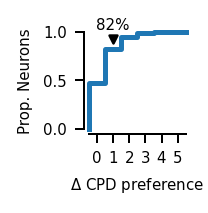

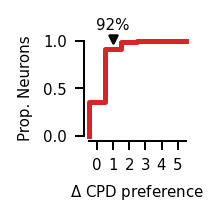

In [55]:
def compare_timescale_preferences_diff(df, conds, spk_type):
    df_sig = df.query(f'({spk_type}_sig_{conds[0]} == True) | ({spk_type}_sig_{conds[1]} == True)')
    units = df_sig.groupby(['m', 's', 'e', 'u'])
    def _get_pref_timescale_diff(series):
        pref_cond0 = np.argmax(series[f'{spk_type}_strength_{conds[0]}'])
        pref_cond1 = np.argmax(series[f'{spk_type}_strength_{conds[1]}'])
        return np.abs(pref_cond0 - pref_cond1)
    diff = units.apply(_get_pref_timescale_diff)
    bins = np.linspace(0, 6, 7) - 0.5
    ax, counts = cumulative_hist(diff, bins, color=COLORS[spk_type])
    ax.set_xticks(bins[:-1] + 0.5)
    ax.set_xlabel(r'$\Delta$ CPD preference')
    ax.set_ylabel('Prop. Neurons')
    ax.scatter(1, np.sum(counts[:2]) + 0.1, s=10, marker='v', color='black')
    ax.text(1, np.sum(counts[:2]) + 0.2, f'{100 * np.sum(counts[:2]):.0f}%', ha='center', fontsize=LABELFONTSIZE)
    return ax

for spk_type in ['tonicspk', 'burst']:
    ax = compare_timescale_preferences_diff(df, subsamples, spk_type)
    clip_axes_to_ticks(ax=ax, ext={'bottom':[-0.5, 0.5]})
    set_plotsize(w=1.5, h=1.5)
    ax.get_figure().savefig(FIGUREPATH + f'best_frequecy_splits_{spk_type}.svg')

### Figure S3E
Neurons with strong monotonic size tuning are those most affected by size-matching.

In [56]:
# Load phase coupling data from gray screen and sparse noise experiments
conditions = ['spontaneous', 'sparsenoise']
df_all = load_data('phasetuning', conditions)
# Coupling data measured after sub-sampling for pupil size matching
df_sizematched = load_data('phasetuning', conditions, subsample='sizematched')

# Assign significance based on p-value from shuffled permutation test
df_all['tonicspk_sig'] = df_all['tonicspk_p'] <= 0.05
df_all['burst_sig'] = df_all['burst_p'] <= 0.05
df_sizematched['tonicspk_sig'] = df_sizematched['tonicspk_p'] <= 0.05
df_sizematched['burst_sig'] = df_sizematched['burst_p'] <= 0.05

# Combine control and sub-sampled data
df_all = df_all.set_index(['m', 's', 'e', 'u', 'imf']).sort_index()
df_sizematched = df_sizematched.set_index(['m', 's', 'e', 'u', 'imf']).sort_index()
suffixes = ['_all', '_sizematched']
df_phasetuning = pd.merge(df_all, df_sizematched, left_index=True, right_index=True, suffixes=suffixes)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl
Loading:  phasetuning_spontaneous_sizematched.pkl
Loading:  phasetuning_sparsenoise_sizematched.pkl


Loading:  sizetuning_spontaneous_burst.pkl
Loading:  sizetuning_sparsenoise_burst.pkl
Chi2ContingencyResult(statistic=9.482519661991745, pvalue=0.008727643900112143, dof=2, expected_freq=array([[17.78666667,  5.02666667,  6.18666667],
       [28.21333333,  7.97333333,  9.81333333]]))
[[12  6 11]
 [34  7  5]]
[46 13 16]


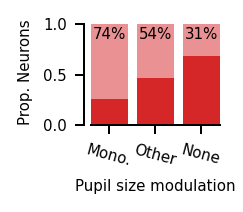

In [57]:
def preferred_timescale_shift(series, spk_type, conds):
    pref0 = np.argmax(series[f'{spk_type}_strength_{conds[0]}'])
    pref1 = np.argmax(series[f'{spk_type}_strength_{conds[1]}'])
    return np.abs(pref0 - pref1) != 0 

units = df_phasetuning.groupby(['m', 's', 'e', 'u'])
units = units.filter(lambda x: x['burst_sig_all'].any() & x['burst_sig_sizematched'].any()).groupby(['m', 's', 'e', 'u'])
timescale_shift = units.apply(lambda x: preferred_timescale_shift(x, 'burst', ['all', 'sizematched']))

df_sizetuning = load_data('sizetuning', conditions, spk_type='burst').set_index(['m', 's', 'e', 'u'])
df_sizetuning['tuning_max'] = df_sizetuning['area_means'].apply(np.argmax)
df_sizetuning['mono'] = df_sizetuning.apply(lambda x: x['tuning_max'] == 0, axis='columns')

df = pd.merge(df_sizetuning, timescale_shift.rename('shift'), on=['m', 's', 'e', 'u'])
df_mono = df.query('(area_p <= 0.05) & (mono == True)')
df_other = df.query('(area_p <= 0.05) & (mono == False)')
df_ns = df.query('(area_p > 0.05)')
counts = np.array([
                   [(~df_mono['shift']).sum(), (~df_other['shift']).sum(), (~df_ns['shift']).sum()],
                   [df_mono['shift'].sum(), df_other['shift'].sum(), df_ns['shift'].sum()]
                  ])

fig, ax = plt.subplots()
ax.bar([0, 1, 2], counts[0] / counts.sum(axis=0), width=0.8, color=COLORS['burst'])
ax.bar([0, 1, 2], counts[1] / counts.sum(axis=0), bottom=(counts[0] / counts.sum(axis=0)), width=0.8, color=COLORS['burst'], alpha=0.5)
for j, c in enumerate(counts.T):
    ax.text(j, 0.85, f'{c[1] / c.sum() * 100:.0f}%', ha='center', fontsize=LABELFONTSIZE)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Mono.', 'Other', 'None'], rotation=-15)
ax.set_xlabel('Pupil size modulation')
ax.set_yticks([0, .5, 1])
ax.set_ylabel('Prop. Neurons')

clip_axes_to_ticks(ax=ax, ext={'bottom':[-0.4, 0.4]})
set_plotsize(w=2, h=1.5, ax=ax)
fig.savefig(FIGUREPATH + 'size_tuning_comparison_timescale_burst.svg')

print(chi2_contingency(counts))
print(counts)
print(counts.sum(axis=0))

Loading:  sizetuning_spontaneous_tonicspk.pkl
Loading:  sizetuning_sparsenoise_tonicspk.pkl
[[26 22  5]
 [37 43  6]]
[63 65 11]


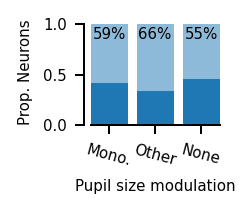

In [59]:
units = df_phasetuning.groupby(['m', 's', 'e', 'u'])
units = units.filter(lambda x: x['tonicspk_sig_all'].any() & x['tonicspk_sig_sizematched'].any()).groupby(['m', 's', 'e', 'u'])
timescale_shift = units.apply(lambda x: preferred_timescale_shift(x, 'tonicspk', ['all', 'sizematched']))

df_sizetuning = load_data('sizetuning', conditions, spk_type='tonicspk').set_index(['m', 's', 'e', 'u'])
df_sizetuning['tuning_max'] = df_sizetuning['area_means'].apply(np.argmax)
df_sizetuning['mono'] = df_sizetuning.apply(lambda x: x['tuning_max'] == 9, axis='columns')

df = pd.merge(df_sizetuning, timescale_shift.rename('shift'), on=['m', 's', 'e', 'u'])
df_mono = df.query('(area_p <= 0.05) & (mono == True)')
df_other = df.query('(area_p <= 0.05) & (mono == False)')
df_ns = df.query('(area_p > 0.05)')
counts = np.array([
                   [(~df_mono['shift']).sum(), (~df_other['shift']).sum(), (~df_ns['shift']).sum()],
                   [df_mono['shift'].sum(), df_other['shift'].sum(), df_ns['shift'].sum()]
                  ])

fig, ax = plt.subplots()
ax.bar([0, 1, 2], counts[0] / counts.sum(axis=0), width=0.8, color=COLORS['tonicspk'])
ax.bar([0, 1, 2], counts[1] / counts.sum(axis=0), bottom=(counts[0] / counts.sum(axis=0)), width=0.8, color=COLORS['tonicspk'], alpha=0.5)
for j, c in enumerate(counts.T):
    ax.text(j, 0.85, f'{c[1] / c.sum() * 100:.0f}%', ha='center', fontsize=LABELFONTSIZE)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Mono.', 'Other', 'None'], rotation=-15)
ax.set_xlabel('Pupil size modulation')
ax.set_yticks([0, .5, 1])
ax.set_ylabel('Prop. Neurons')

clip_axes_to_ticks(ax=ax, ext={'bottom':[-0.4, 0.4]})
set_plotsize(w=2, h=1.5, ax=ax)
fig.savefig(FIGUREPATH + 'size_tuning_comparison_timescale_tonicspk.svg')

chi2_contingency(counts)
print(counts)
print(counts.sum(axis=0))

### Figure S4A3 
Burst ratios during quiescence and various time periods relative to locomotion.

In [60]:
df_spikes = load_data('spikes', ['spontaneous', 'sparsenoise'])
df_spikes = filter_units(df_spikes, MINRATE)
df_run = load_data('ball', ['spontaneous', 'sparsenoise'])
df = pd.merge(df_run, df_spikes, on=['m', 's', 'e']).set_index(['m', 's', 'e', 'u'])

Loading:  spikes_spontaneous.pkl
Loading:  spikes_sparsenoise.pkl
Loading:  ball_spontaneous.pkl
Loading:  ball_sparsenoise.pkl


In [61]:
def take_events_in_bouts(series, data, bouts, trange=None, dt=2):
    header, _ = data.split('_')
    events_in_bouts = []
    for t0, t1 in series['%s_bouts' % bouts]:
        if trange == 'start':
            t1 = t0 + dt
        elif trange == 'end':
            t0 = t1 - dt
        elif trange == 'middle':
            t0 = t0 + dt
            t1 = t1 - dt
        if (t1 - t0) <= 0:
            continue
        events_in_bouts.append(series[data][(series[data] >= t0) & (series[data] <= t1)])
    return np.concatenate(events_in_bouts)

# TODO: just use list with state_trange
states = {'sit0':'middle', 'run0':'start', 'run1':'middle', 'run2':'end'}
brs = {}
means = {}
errs = {}
for state, trange in states.items():
    df['burstspks_%s' % state] = df.apply(take_events_in_bouts, data='burstspk_times', bouts=state[:-1], trange=trange, axis='columns')
    df['spks_%s' % state] = df.apply(take_events_in_bouts, data='spk_times', bouts=state[:-1], trange=trange, axis='columns')
    df['burst_%s' % state] = df.apply(take_events_in_bouts, data='burst_times', bouts=state[:-1], trange=trange, axis='columns')
    br = df.query('spks_%s.str.len() > 0' % state).apply(lambda x: len(x['burstspks_%s' % state]) / len(x['spks_%s' % state]), axis='columns')
    brs[state] = br
    means[state] = br.median()
    errs[state] = se_median(br)
df_brs = pd.concat([v.rename(k) for k, v in brs.items()], axis=1).dropna()
friedmanchisquare(*df_brs.values.T)

FriedmanchisquareResult(statistic=21.95538461538432, pvalue=6.664040651685976e-05)

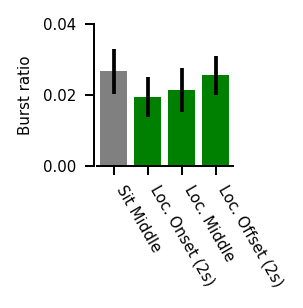

In [62]:
fig, ax = plt.subplots()
for pos, (state, _) in enumerate(states.items()):
    ax.bar(pos, means[state], yerr=errs[state], color=COLORS[state[:-1]])
ax.set_xticks(np.arange(len(states)))
ax.set_xticklabels(['Sit Middle', 'Loc. Onset (2s)', 'Loc. Middle', 'Loc. Offset (2s)'], rotation=300, ha='left')
ax.set_yticks([0, 0.02, 0.04])
ax.set_ylabel('Burst ratio')
clip_axes_to_ticks(ax=ax, ext={'bottom':[-0.5, 0.5]})
set_plotsize(w=2, h=2)
fig.savefig(FIGUREPATH + 'burstratio_run_sit.svg')

### Figure S4A, S5C1
Run-, sit-, and saccade-triggered spiking.

In [63]:
conditions = ['spontaneous', 'sparsenoise']
df = load_data('responses', conditions).dropna()

Loading:  responses_spontaneous.pkl
Loading:  responses_sparsenoise.pkl


Sit tonicspk: 0.917 (111 / 121)
Sit burst: 0.818 (99 / 121)
Run tonicspk: 0.893 (108 / 121)
Run burst: 0.793 (96 / 121)
Saccade tonicspk: 0.975 (118 / 121)
Saccade burst: 0.744 (90 / 121)


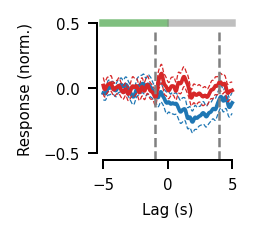

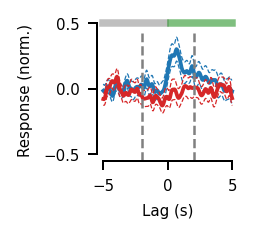

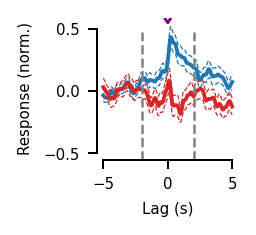

In [64]:
for event in ['sit', 'run', 'saccade']:
    
    fig, ax = plt.subplots()
    
    for spk_type in ['tonicspk', 'burst']:
        df_sig = df.query(f'{event}_{spk_type}_sig == True')
        df_resp = df_sig[f'{event}_{spk_type}_response']
        responses = np.row_stack(df_resp.apply(lambda x: x / np.abs(x).max()))
        mean = responses.mean(axis=0)
        err = sem(responses, axis=0) * 1.96
        tpts = df_sig[f'{event}_{spk_type}_tpts'].iloc[0]
        ax.plot(tpts, mean, color=COLORS[spk_type])
        ax.plot(tpts, mean - err, lw=0.5, ls='--', color=COLORS[spk_type])
        ax.plot(tpts, mean + err, lw=0.5, ls='--', color=COLORS[spk_type])
        print(f'{event.capitalize()} {spk_type}: {len(df_sig)/len(df):.3f} ({len(df_sig)} / {len(df)})')
        
    ax.axvline(BEHAVEXCLUSIONS[event][0], ymax=0.9, ls='--', lw=1, color='gray')
    ax.axvline(BEHAVEXCLUSIONS[event][1], ymax=0.9, ls='--', lw=1, color='gray')
    if event == 'sit':
        ax.plot([-5, -0.25], [0.5, 0.5], lw=3, alpha=0.5, color=COLORS['run'])
        ax.plot([0.25, 5], [0.5, 0.5], lw=3, alpha=0.5, color=COLORS['sit'])
    elif event == 'run':
        ax.plot([-5, -0.25], [0.5, 0.5], lw=3, alpha=0.5, color=COLORS['sit'])
        ax.plot([0.25, 5], [0.5, 0.5], lw=3, alpha=0.5, color=COLORS['run'])
    elif event == 'saccade':
        ax.scatter([0, 0], [0.55, 0.55], lw=1, s=7, marker=7, fc='none', ec=COLORS['saccade'])
        

    ax.set_xticks([tpts.min(), 0, tpts.max()])
    ax.set_xlabel('Lag (s)')
    ax.set_yticks([-0.5, 0, 0.5])
    ax.set_ylim(bottom=-0.55)
    ax.set_ylabel('Response (norm.)')

    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=2, h=2)
    
    fig.savefig(FIGUREPATH + f'mean_{event}_response.svg')

### Figure S5C3
Peri-saccadic modulation index for each spike type

tonicspk AUCs > 0: 105/118(88.98)
0.20354414330917253
WilcoxonResult(statistic=543.0, pvalue=1.598717146350466e-15)
burst AUCs > 0: 33/90(36.67)
-0.06178675404301504
WilcoxonResult(statistic=1367.0, pvalue=0.0061791483476051675)


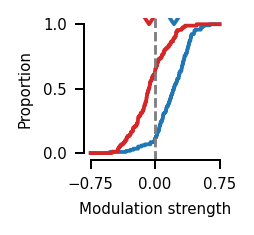

In [65]:
for trigger in ['saccade']:
    fig, ax = plt.subplots()

    for spk_type in ['tonicspk', 'burst']:
        i0, i1 = df['%s_%s_tpts' % (trigger, spk_type)].iloc[0].searchsorted(BEHAVEXCLUSIONS[trigger])
        df['%s_%s_auc' % (trigger, spk_type)] = np.row_stack(df['%s_%s_response' % (trigger, spk_type)].apply(lambda x: x[i0:i1] / np.abs(x).max())).mean(axis=1)
        df_sig = df.query('%s_%s_sig == True' % (trigger, spk_type))

        aucs = df_sig['%s_%s_auc' % (trigger, spk_type)]
        print("%s AUCs > 0: %d/%d(%.2f)" % (spk_type, (aucs > 0).sum(), len(aucs), (aucs > 0).mean() * 100))
        print(aucs.mean())
        weights = np.ones_like(aucs) / len(aucs)
        vals, bins = np.histogram(aucs, bins=np.linspace(-0.75, 0.75, 1001), weights=weights)
        xvals = bins[:-1] + np.diff(bins).mean() / 2
        ax.plot(xvals, np.cumsum(vals), color=COLORS[spk_type])

        ax.scatter(np.median(aucs), 1, marker=7, fc='none', ec=COLORS[spk_type])
        ax.axvline(0, ls='--', lw=1, color='gray')
        # print(wilcoxon(aucs, alternative='greater'))
        print(wilcoxon(aucs))

    ax.set_xticks([-0.75, 0, 0.75])
    ax.set_xlabel('Modulation strength')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel('Proportion')

    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=2, h=2)

    fig.savefig(FIGUREPATH + '%s_modulation.svg' % trigger)

### Figure S5D
Correlation of saccade modulation index and CPD phase coupling for each neuron.

In [66]:
conditions = ['spontaneous', 'sparsenoise']
df_phasetuning = load_data('phasetuning', conditions)

df_phasetuning['tonicspk_sig'] = df_phasetuning['tonicspk_p'] <= 0.05
df_phasetuning['burst_sig'] = df_phasetuning['burst_p'] <= 0.05
# TODO: replace with sort_data function from util
df_phasetuning['freq_bin'] = np.digitize(df_phasetuning['freq'], bins=FREQUENCYBINS) - 1

df = pd.merge(df, df_phasetuning)

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl


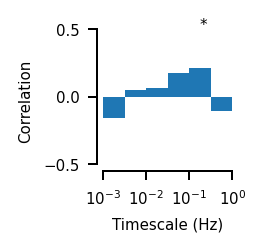

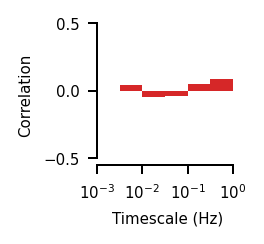

In [67]:
for spk_type in ['tonicspk', 'burst']:
    fig, ax = plt.subplots()
    for xpos, (freqbin, group) in zip(FREQUENCYXPOS, df.groupby('freq_bin')):
        group = group.query(f'({spk_type}_sig == True) & (saccade_{spk_type}_sig == True)')
        if len(group) <= 5:
            continue
        r, p = pearsonr(group[f'saccade_{spk_type}_auc'], group[f'{spk_type}_strength'])
        ax.bar(xpos, r, width=0.5, color=COLORS[spk_type])
        ax.text(xpos, 0.5, p2stars(p), fontsize=LABELFONTSIZE)

    ax.set_xticks(FREQUENCYTICKS)
    ax.set_xticklabels(FREQUENCYTICKLABELS)
    ax.set_xlabel('Timescale (Hz)')
    ax.set_yticks([-0.5, 0, 0.5])
    ax.set_ylim(bottom=-0.55)
    ax.set_ylabel('Correlation')

    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=2, h=2)
    
    fig.savefig(FIGUREPATH + f'phasetuning_saccade_response_correlation_{spk_type}.svg')

### Figure S4B
Correlation between CPDs and running speed.

In [68]:
conditions = ['spontaneous', 'sparsenoise']
df = load_data('imfcorr', conditions)

df['freq_bin'] = np.digitize(df['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1) - 1

lags = np.linspace(-30, 30, 1000)
df['xcorr_tpts'] = df['xcorr_lags']
df['xcorr'] = df.apply(lambda x: interpolate(x['xcorr'], x['xcorr_lags'], lags), axis='columns')

print("IMFs significantly correlated: %.1f" % (100 * df['xcorr_sig'].mean()))
print(df['xcorr_sig'].sum(), len(df))

Loading:  imfcorr_spontaneous.pkl
Loading:  imfcorr_sparsenoise.pkl
IMFs significantly correlated: 55.3
52 94


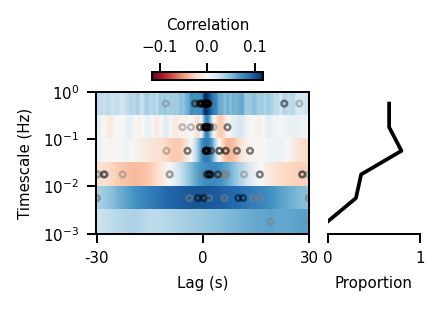

In [69]:
fig, ax = plt.subplots()

sorted_xcorrs = sort_data(df['xcorr'], df['freq'], bins=FREQUENCYBINS)
xcorr_mat = np.row_stack([np.row_stack(xcorrs).mean(axis=0) for xcorrs in sorted_xcorrs]) 
xcorr_max = np.abs(xcorr_mat).max()
mat = ax.matshow(xcorr_mat, aspect='auto', vmin=-xcorr_max, vmax=xcorr_max, cmap='RdBu')

for sig, color, alpha in zip([False, True], ['gray', 'black'], [0.5, 1]):
    df_sig = df.query(f'xcorr_sig == {sig}')
    sorted_peaks = sort_data(df_sig['xcorr_peak'], df_sig['freq'], bins=FREQUENCYBINS)
    for i, peaks in enumerate(sorted_peaks):
        ax.scatter(lags.searchsorted(peaks), np.ones(len(peaks)) * i, s=5, fc='none', ec=color, alpha=0.5)
        
lagticks = [-30, 0, 30]
ax.set_xticks(lags.searchsorted(lagticks))
ax.set_xticklabels(lagticks)
ax.xaxis.tick_bottom()
ax.set_xlabel("Lag (s)")
ax.set_yticks(np.arange(len(FREQUENCYBINS))[::2] - 0.5)
ax.set_yticklabels(FREQUENCYTICKLABELS)
ax.invert_yaxis()
ax.set_ylabel("Timescale (Hz)")

fig.subplots_adjust(bottom=0.3, right=0.7)
bbox = ax.get_position()

cax = fig.add_axes([bbox.x0 + 0.15, bbox.y1 + 0.05, 0.3, 0.03])
cbar = plt.colorbar(mat, cax=cax, orientation='horizontal', label='Correlation')
cbar.set_ticks([-0.1, 0, 0.1])
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

ax_prop = fig.add_axes([bbox.x1 + 0.05, bbox.y0, 0.25, bbox.height])
sig = sort_data(df['xcorr_sig'], df['freq'], bins=FREQUENCYBINS)
ax_prop.plot([s.mean() for s in sig], np.arange(len(FREQUENCYBINS))[:-1] + 0.5, color='black')
ax_prop.set_xticks([0, 1])
ax_prop.set_xlim(left=0, right=1)
ax_prop.set_xlabel('Proportion')
ax_prop.set_ylim(bottom=0, top=len(FREQUENCYBINS) - 1)
ax_prop.yaxis.set_visible(False)
clip_axes_to_ticks(ax=ax_prop, spines=['bottom'])

set_plotsize(w=3, h=2, ax=ax)
fig.savefig(FIGUREPATH + "imf_run_correlation.svg")

In [70]:
df_phasetuning = load_data('phasetuning', ['spontaneous', 'sparsenoise'])
df_phasetuning['freq'] = np.round(df_phasetuning['freq'], decimals=4)
df_phasetuning['tonicspk_sig'] = df_phasetuning['tonicspk_p'] <= 0.05
df_phasetuning['burst_sig'] = df_phasetuning['burst_p'] <= 0.05
df = pd.merge(df_phasetuning, df, on=['m', 's', 'e', 'imf'])

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl


In [71]:
# Loop over spike types
for spk_type in ['burst', 'tonicspk']:
    # Restrict to entries where tuning was evaluated
    df_valid = df.dropna(subset=f'{spk_type}_strength')

    # Build contingency table
    rxc_table = np.array([
        [len(df_valid.query(f'({spk_type}_sig == False) & (xcorr_sig == False)')), len(df_valid.query(f'({spk_type}_sig == False) & (xcorr_sig == True)'))],
        [len(df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == False)')), len(df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == True)'))]
        ])
    # Perform chi2 contingency test
    print(f"Chi2: {spk_type} tuning - IMF run speed correlation")
    chi2, p, dof, expected = chi2_contingency(rxc_table)
    propsig = rxc_table[1, 0] / rxc_table[:, 0].sum()
    print(f"Significant tuning for uncorrelated IMFs: {propsig:.3f} ({rxc_table[1, 0]}/{rxc_table[:, 0].sum()})")
    propsig = rxc_table[1, 1] / rxc_table[:, 1].sum()
    print(f"Significant tuning for correlated IMFs: {propsig:.3f} ({rxc_table[1, 1]}/{rxc_table[:, 1].sum()})")
    print(f"chi2 = {chi2:.2e}, p = {p:.2e}")

    # Compare coupling strengths
    strength_sig = df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == True)')[f'{spk_type}_strength']
    strength_ns = df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == False)')[f'{spk_type}_strength']
    print(mannwhitneyu(strength_sig, strength_ns))
    print(f"Strength uncorrelated = {strength_ns.median():.4f}")
    print(f"Strength correlated = {strength_sig.median():.4f}", "\n")

Chi2: burst tuning - IMF run speed correlation
Significant tuning for uncorrelated IMFs: 0.503 (186/370)
Significant tuning for correlated IMFs: 0.382 (128/335)
chi2 = 9.87e+00, p = 1.68e-03
MannwhitneyuResult(statistic=8683.0, pvalue=4.625688574517385e-05)
Strength uncorrelated = 0.0678
Strength correlated = 0.0326 

Chi2: tonicspk tuning - IMF run speed correlation
Significant tuning for uncorrelated IMFs: 0.759 (341/449)
Significant tuning for correlated IMFs: 0.735 (305/415)
chi2 = 5.64e-01, p = 4.53e-01
MannwhitneyuResult(statistic=46645.0, pvalue=0.023684398941296883)
Strength uncorrelated = 0.0102
Strength correlated = 0.0064 



### Figure S4C
Correlation between CPDs and running speed only in locomotion bouts (i.e. fine-grained locomotion speed info).

In [72]:
conditions = ['spontaneous', 'sparsenoise']
df = load_data('imfcorr', conditions, tranges='run')

df['freq_bin'] = np.digitize(df['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1) - 1

lags = np.linspace(-30, 30, 1000)
df['xcorr_tpts'] = df['xcorr_lags']
df['xcorr'] = df.apply(lambda x: interpolate(x['xcorr'], x['xcorr_lags'], lags), axis='columns')

print("IMFs significantly correlated: %.1f" % (100 * df['xcorr_sig'].mean()))
print(df['xcorr_sig'].sum(), len(df))

Loading:  imfcorr_spontaneous_run.pkl
Loading:  imfcorr_sparsenoise_run.pkl
IMFs significantly correlated: 64.9
61 94


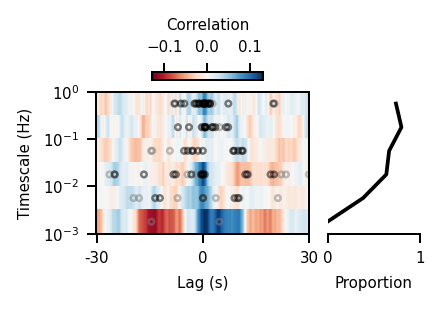

In [73]:
fig, ax = plt.subplots()

sorted_xcorrs = sort_data(df['xcorr'], df['freq'], bins=FREQUENCYBINS)
xcorr_mat = np.row_stack([np.row_stack(xcorrs).mean(axis=0) for xcorrs in sorted_xcorrs]) 
xcorr_max = np.abs(xcorr_mat).max()
mat = ax.matshow(xcorr_mat, aspect='auto', vmin=-xcorr_max, vmax=xcorr_max, cmap='RdBu')

for sig, color, alpha in zip([False, True], ['gray', 'black'], [0.5, 1]):
    df_sig = df.query(f'xcorr_sig == {sig}')
    sorted_peaks = sort_data(df_sig['xcorr_peak'], df_sig['freq'], bins=FREQUENCYBINS)
    for i, peaks in enumerate(sorted_peaks):
        ax.scatter(lags.searchsorted(peaks), np.ones(len(peaks)) * i, s=5, fc='none', ec=color, alpha=0.5)
        
lagticks = [-30, 0, 30]
ax.set_xticks(lags.searchsorted(lagticks))
ax.set_xticklabels(lagticks)
ax.xaxis.tick_bottom()
ax.set_xlabel("Lag (s)")
ax.set_yticks(np.arange(len(FREQUENCYBINS))[::2] - 0.5)
ax.set_yticklabels(FREQUENCYTICKLABELS)
ax.invert_yaxis()
ax.set_ylabel("Timescale (Hz)")

fig.subplots_adjust(bottom=0.3, right=0.7)
bbox = ax.get_position()

cax = fig.add_axes([bbox.x0 + 0.15, bbox.y1 + 0.05, 0.3, 0.03])
cbar = plt.colorbar(mat, cax=cax, orientation='horizontal', label='Correlation')
cbar.set_ticks([-0.1, 0, 0.1])
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

ax_prop = fig.add_axes([bbox.x1 + 0.05, bbox.y0, 0.25, bbox.height])
sig = sort_data(df['xcorr_sig'], df['freq'], bins=FREQUENCYBINS)
ax_prop.plot([s.mean() for s in sig], np.arange(len(FREQUENCYBINS))[:-1] + 0.5, color='black')
ax_prop.set_xticks([0, 1])
ax_prop.set_xlim(left=0, right=1)
ax_prop.set_xlabel('Proportion')
ax_prop.set_ylim(bottom=0, top=len(FREQUENCYBINS) - 1)
ax_prop.yaxis.set_visible(False)
clip_axes_to_ticks(ax=ax_prop, spines=['bottom'])

set_plotsize(w=3, h=2, ax=ax)
fig.savefig(FIGUREPATH + "imf_run_correlation_run.svg")

In [74]:
df_phasetuning = load_data('phasetuning', ['spontaneous', 'sparsenoise'])
df_phasetuning['freq'] = np.round(df_phasetuning['freq'], decimals=4)
df_phasetuning['tonicspk_sig'] = df_phasetuning['tonicspk_p'] <= 0.05
df_phasetuning['burst_sig'] = df_phasetuning['burst_p'] <= 0.05
df = pd.merge(df_phasetuning, df, on=['m', 's', 'e', 'imf'])

Loading:  phasetuning_spontaneous.pkl
Loading:  phasetuning_sparsenoise.pkl


In [75]:
# Loop over spike types
for spk_type in ['burst', 'tonicspk']:
    # Restrict to entries where tuning was evaluated
    df_valid = df.dropna(subset=f'{spk_type}_strength')

    # Build contingency table
    rxc_table = np.array([
        [len(df_valid.query(f'({spk_type}_sig == False) & (xcorr_sig == False)')), len(df_valid.query(f'({spk_type}_sig == False) & (xcorr_sig == True)'))],
        [len(df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == False)')), len(df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == True)'))]
        ])
    # Perform chi2 contingency test
    print(f"Chi2: {spk_type} tuning - IMF run speed correlation")
    chi2, p, dof, expected = chi2_contingency(rxc_table)
    propsig = rxc_table[1, 0] / rxc_table[:, 0].sum()
    print(f"Significant tuning for uncorrelated IMFs: {propsig:.3f} ({rxc_table[1, 0]}/{rxc_table[:, 0].sum()})")
    propsig = rxc_table[1, 1] / rxc_table[:, 1].sum()
    print(f"Significant tuning for correlated IMFs: {propsig:.3f} ({rxc_table[1, 1]}/{rxc_table[:, 1].sum()})")
    print(f"chi2 = {chi2:.2e}, p = {p:.2e}")

    # Compare coupling strengths
    strength_sig = df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == True)')[f'{spk_type}_strength']
    strength_ns = df_valid.query(f'({spk_type}_sig == True) & (xcorr_sig == False)')[f'{spk_type}_strength']
    print(mannwhitneyu(strength_sig, strength_ns))
    print(f"Strength uncorrelated = {strength_ns.median():.4f}")
    print(f"Strength correlated = {strength_sig.median():.4f}", "\n")

Chi2: burst tuning - IMF run speed correlation
Significant tuning for uncorrelated IMFs: 0.307 (58/189)
Significant tuning for correlated IMFs: 0.496 (256/516)
chi2 = 1.93e+01, p = 1.12e-05
MannwhitneyuResult(statistic=8140.0, pvalue=0.2517663418863203)
Strength uncorrelated = 0.0414
Strength correlated = 0.0595 

Chi2: tonicspk tuning - IMF run speed correlation
Significant tuning for uncorrelated IMFs: 0.687 (169/246)
Significant tuning for correlated IMFs: 0.772 (477/618)
chi2 = 6.27e+00, p = 1.23e-02
MannwhitneyuResult(statistic=45918.0, pvalue=0.007115552089052142)
Strength uncorrelated = 0.0054
Strength correlated = 0.0099 



### Figure S5A
Example saccades.

In [76]:
df_pupil = load_data('pupil', ['sparsenoise', 'spontaneous']).set_index(['m', 's', 'e'])

Loading:  pupil_sparsenoise.pkl
Loading:  pupil_spontaneous.pkl


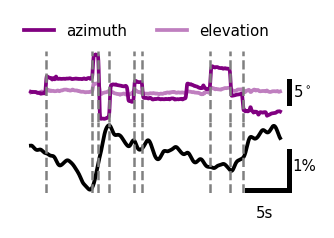

In [77]:
# TODO: move this to parameters
key = {'m': 'PVCre_2019_0002', 's': 7, 'e':9}
t0, t1 = 175, 205

fig, (ax_pos, ax_area) = plt.subplots(2, sharex=True)

tpts = df_pupil['pupil_tpts'].loc[key2idx(key)]
i0, i1 = tpts.searchsorted([t0, t1])

area = df_pupil['pupil_area'].loc[key2idx(key)]
ax_area.plot(tpts[i0:i1], area[i0:i1], color='black')
ax_area.xaxis.set_visible(False)
ax_area.yaxis.set_visible(False)
ax_area.set_frame_on(False)

for label in ['azimuth', 'elevation']:
    pos = df_pupil['pupil_%s' % label].loc[key2idx(key)][i0:i1]
    pos = pos - np.nanmedian(pos)
    ax_pos.plot(tpts[i0:i1], pos, color=COLORS[label], label=label)
ax_pos.legend(loc=(0, 1.1), ncol=2, frameon=False)
ax_pos.xaxis.set_visible(False)
ax_pos.yaxis.set_visible(False)
ax_pos.set_frame_on(False)

saccades = df_pupil['saccade_times'].loc[key2idx(key)]
saccades = saccades[(saccades >= t0) & (saccades <= t1)]
for saccade in saccades:
    ax_pos.axvline(saccade, lw=1, ls='--', color='gray')
    ax_area.axvline(saccade, lw=1, ls='--', color='gray')

ax_area.plot([t1 - 4, t1 + 1], [area[i0:i1].min(), area[i0:i1].min()], lw=2, color='black')
ax_area.text(t1 - 3, area[i0:i1].min() - 0.007, '5s', fontsize=LABELFONTSIZE)
ax_area.plot([t1 + 1, t1 + 1], [area[i0:i1].min(), area[i0:i1].min() + 0.01], lw=2, color='black')
ax_area.text(t1 + 1.5, area[i0:i1].min() + 0.005, '1%', fontsize=LABELFONTSIZE)
ax_pos.plot([t1 + 1, t1 + 1], [-2.5, 2.5], lw=2, color='black')
ax_pos.text(t1 + 1.5, -1, '5$^\circ$', fontsize=LABELFONTSIZE)

fig.subplots_adjust(hspace=0)
set_plotsize(w=4, h=2)

fig.savefig(FIGUREPATH + 'saccade_example.svg')

### Figure S5B
Saccade-CPD coupling.

In [78]:
df_saccades = load_data('phasetuning', ['sparsenoise', 'spontaneous'], s='saccades')
df_saccades['saccade_sig'] = df_saccades['saccade_p'] <= 0.05
df_saccades['freq_bin'] = np.digitize(df_saccades['freq'], bins=FREQUENCYBINS).clip(1, len(FREQUENCYBINS) - 1) - 1
saccade_tuning = []
# As a work-around implementation, the same analysis is repeated for all units in an experiment
# so here we take only the first unit from each experiment
for idx, group in df_saccades.groupby(['m', 's', 'e', 'freq']):
    saccade_tuning.append(group.iloc[0].drop('u'))
df_saccades = pd.DataFrame(saccade_tuning)

Loading:  phasetuning_sparsenoise_saccades.pkl
Loading:  phasetuning_spontaneous_saccades.pkl


In [79]:
n_sig = df_saccades.groupby(['m', 's', 'e']).apply(lambda x: any(x['saccade_sig'])).sum()
n_exp = len(df_saccades.groupby(['m', 's', 'e']))
print(n_sig, n_exp)
n_cpds = df_saccades.groupby(['m', 's', 'e']).apply(lambda x: sum(x['saccade_sig'])).mean()
print(n_cpds)
phase = circmean_angle(df_saccades['saccade_phase'])
print(phase)

15 15
3.6666666666666665
-1.0064810840100598


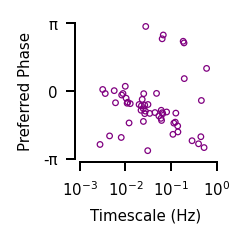

In [80]:
fig, ax = plt.subplots()

df_sig = df_saccades.query('saccade_sig == True')
freq = np.log10(df_sig['freq'])
phase = df_sig['saccade_phase']
ax.scatter(freq, phase, ec='purple', fc='none', s=5, lw=0.5)

# adjust x-axis
ax.set_xticks(FREQUENCYTICKS)
ax.set_xticklabels(FREQUENCYTICKLABELS)
ax.set_xlim(left=-3.1)
ax.set_xlabel("Timescale (Hz)")

# adjust y-axis
ax.set_yticks(PHASETICKS)
ax.set_yticklabels(PHASETICKLABELS)
ax.set_ylim([-np.pi - 0.15, np.pi + 0.15])
ax.set_ylabel("Preferred Phase")

set_plotsize(w=2, h=2)
clip_axes_to_ticks(ax=ax)
fig.savefig(FIGUREPATH + 'phase_tuning_scatter_saccades.svg')

### Figure S5C2
Clustering of saccade-triggered spiking.

In [81]:
conditions = ['spontaneous', 'sparsenoise']
df = load_data('responses', conditions).dropna()

tpts = df['saccade_tonicspk_tpts'].iloc[0]
i0, i1 = tpts.searchsorted([-1, 1])
# Set spiking to zero if neuron doesn't meaningfully (so that noise doesn't influence clustering)
df['saccade_tonicspk_response'].apply(lambda x: x if ((np.abs(x).max() / x.mean()) < 1.1) & ((x.max() - x.min()) < 1) else np.zeros_like(x))
sta = np.row_stack(df['saccade_tonicspk_response'].apply(lambda x: x[i0:i1] / np.abs(x).max()))

Loading:  responses_spontaneous.pkl
Loading:  responses_sparsenoise.pkl


In [82]:
# Note: this cell involves randmoization, and will therefore not always return the same results
# but multiple re-runs will demonstrate that the main conclusions are robust
pca = PCA().fit((sta.T - sta.mean(axis=1)).T)
variance = np.cumsum(pca.explained_variance_ratio_)
n_dims = np.where(variance > 0.8)[0][0]
print(n_dims)

sta_pcs = pca.transform(sta)

n_clusters = 3
labels = KMeans(n_clusters=n_clusters).fit_predict(sta_pcs[:, :n_dims])

3


/home/crombie/miniconda3/envs/djd/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


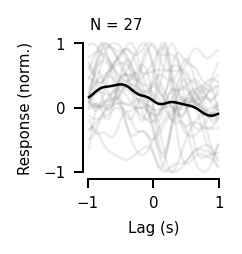

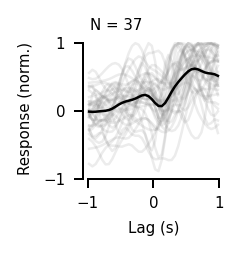

In [83]:
sta = np.row_stack(df['saccade_tonicspk_response'].apply(lambda x: x[i0:i1] / np.abs(x).max()))
for label in range(n_clusters):
    fig, ax = plt.subplots()
    n_units = len(sta[labels == label])
    for unit in sta[labels == label]:
        ax.plot(tpts[i0:i1], unit, lw=1, color='gray', alpha=0.15)
    mean = np.mean(sta[labels == label], axis=0) 
    ci = sem(sta[labels == label], axis=0) * 1.96
    ax.plot(tpts[i0:i1], mean, lw=1, color='black')
    ax.text(0.05, 1.05, 'N = %d' % n_units, transform=ax.transAxes, fontsize=LABELFONTSIZE)
    ax.set_xticks([-1, 0, 1])
    ax.set_xlabel('Lag (s)')
    ax.set_yticks([-1, 0, 1])
    ax.set_ylabel('Response (norm.)')
    
    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=2, h=2)
    # fig.savefig(FIGUREPATH + f'saccade_response_cluster{label}.svg')

In [84]:
conditions = ['natmov', 'natmov_opto']

df_decoding = load_data('imfdecoding', conditions)
df_decoding.rename({'tonicspk_phase':'tonicspk_score', 'burst_phase':'burst_score'}, inplace=True, axis='columns')
df_tuning = load_data('phasetuning', conditions, tranges='noopto')

df = pd.merge(df_decoding, df_tuning).set_index(['m', 's', 'e', 'u', 'imf'])
df['tonicspk_sig'] = df['tonicspk_p'] <= 0.05
df['burst_sig'] = df['burst_p'] <= 0.05

Loading:  imfdecoding_natmov.pkl
Loading:  imfdecoding_natmov_opto.pkl
Loading:  phasetuning_natmov_noopto.pkl
Loading:  phasetuning_natmov_opto_noopto.pkl


tonicspk N = 273
burst N = 68


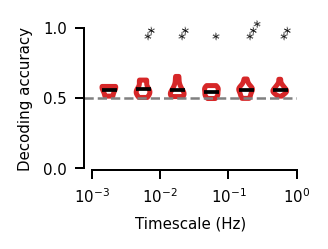

In [85]:
positions = np.log10(FREQUENCYBINS[:-1]) + 0.25
for spike_type in ['tonicspk', 'burst']:
    fig, ax = plt.subplots()
    df_sig = df.query('%s_sig == True' % spike_type)
    print(f"{spike_type} N = {len(df_sig)}")
    scores = sort_data(df_sig['%s_score' % spike_type], df_sig['freq'], bins=FREQUENCYBINS)
    violins = ax.violinplot(scores, positions, widths=0.2, showextrema=False)
    for violin in violins['bodies']:
        violin.set_facecolor('none')
        violin.set_edgecolor(COLORS[spike_type])
        violin.set_linewidth(2)
        violin.set_alpha(1)
    ax.scatter(positions, [s.mean() for s in scores], marker='_', color='black')
    ax.axhline(0.5, ls='--', lw=1, color='gray')
    for position, s in zip(positions, scores):
        w, p = wilcoxon(s - 0.5)
        ax.text(position, 0.9, p2stars(p), rotation=60, fontsize=LABELFONTSIZE)
    ax.set_xticks(FREQUENCYTICKS)
    ax.set_xticklabels(FREQUENCYTICKLABELS)
    ax.set_xlim(left=-3.11)
    ax.set_xlabel('Timescale (Hz)')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(bottom=-0.01)
    ax.set_ylabel('Decoding accuracy')
    clip_axes_to_ticks(ax=ax)
    set_plotsize(w=3, h=2)
    fig.savefig(FIGUREPATH + 'imf_decoding_%s.svg' % spike_type)